# Mitigating Churn in Financial Services


Churn prediction involves leveraging data insights to anticipate customer churn and intervene in a timely manner.

This notebook is to do the data analysis and predictions on the `churn.csv` file.


The first step in the Data Preprocessing is to import the libraries, load the data and do some Exploratory Data Analysis (EDA).

### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from xgboost import XGBClassifier as XGB
import lightgbm as lgb

# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Defining useful functions:

In [ ]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Importing the dataset

In [ ]:
dataset = pd.read_csv('churn.csv')

## 1. Exploratory Data Analysis

Printing the first rows of the dataset:

In [ ]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Checking if there is any missing data in the dataset:

In [ ]:
dataset.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

The dataset has no missing values.

In [ ]:
round(dataset.describe(),3)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,1.000000e+04,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,1.569094e+07,650.529,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204
std,2886.896,7.193619e+04,96.653,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403
min,1.000,1.556570e+07,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,2500.750,1.562853e+07,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,5000.500,1.569074e+07,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,7500.250,1.575323e+07,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.248,0.000
max,10000.000,1.581569e+07,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


Computing the number of exited and not exited clients:

In [ ]:
exited = len(dataset[dataset['Exited'] == 1]['Exited'])
not_exited = len(dataset[dataset['Exited'] == 0]['Exited'])
exited_perc = round(exited/len(dataset)*100,1)
not_exited_perc = round(not_exited/len(dataset)*100,1)

print('Number of clients that have exited the program: {} ({}%)'.format(exited, exited_perc))
print('Number of clients that haven\'t exited the program: {} ({}%)'.format(not_exited, not_exited_perc))

Number of clients that have exited the program: 2037 (20.4%)
Number of clients that haven't exited the program: 7963 (79.6%)


So, around of 20% of the clients exited the bank, while around 80% stayed. As the goal here is to identify which of the customers are at higher risk to discontinue their services with the bank, we are dealing with a classification problem.

A important point to take into consideration here is that we are dealing with an __imbalanced dataset__.

In [ ]:
country = list(dataset['Geography'].unique())
gender = list(dataset['Gender'].unique())

print(country)
print(gender)

['France', 'Spain', 'Germany']
['Female', 'Male']


In the dataset, there are more men (55%) than women (45%), and it has only 3 different countries: France, Spain, and Germany. Where 50% of the customers are from France and 25% are from Germany, and the other group are from Spain.

Now, let's just check the relationship between the features and the outcome ('Exited').

## 2. Predictive Models

### Separating Dataset into X and y subsets

In this project we will test the following models and choose the best one based on the accuracy, balanced accuracy, and Exited Recall.

Models to be tested:
* Logistic Regresstion (Package: Sklearn)
* K-NN (Package: Sklearn)
* Linear SVM, Kernel SVM
* Naive Bayes
* Decision Tree
* Random Forest
* Multi Layers Perceptron - MLP (Package: Sklearn)
* XGBoost (Package: XGBoost)
* XGB: Gradient Boosting Classifier (Package: Sklearn)
* Ada Boosting
* Cat Boosting
* LDA Classifier
* QDA Classifier
* Light GBM (Package: LightGBM)


As we have __imbalanced dataset__, we will test all the models defined above using two different strategies:
1. Complete training set (80% of the dataset)
2. Balanced training set, where we randomly select from the complete tranning set the same number of Stayed and Exited customers.





### 2.1 One-Hot encoding Categorical Attributes

In [ ]:
# One-Hot encoding our categorical attributes
list_cat = ['Geography', 'Gender']
dataset = pd.get_dummies(dataset, columns = list_cat, prefix = list_cat)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [ ]:
dataset = dataset.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [ ]:
dataset.info()

In [ ]:
features = list(dataset.drop('Exited', axis = 1))
target = 'Exited'

### 2.2 Splitting the dataset into the Training set and Test set

Now, let's split the data intro train and test sets (80% and 20%, respectively).

In [ ]:
train, test = train_test_split(dataset, test_size = 0.25, random_state = 1)

print('Number of clients in the dataset: {}'.format(len(dataset)))
print('Number of clients in the train set: {}'.format(len(train)))
print('Number of clients in the test set: {}'.format(len(test)))

Number of clients in the dataset: 10000
Number of clients in the train set: 7500
Number of clients in the test set: 2500


In [ ]:
exited_train = len(train[train['Exited'] == 1]['Exited'])
exited_train_perc = round(exited_train/len(train)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Complete Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_train, exited_train_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

Complete Train set - Number of clients that have exited the program: 1517 (20.2%)
Test set - Number of clients that haven't exited the program: 520 (20.8%)


### 2.3 Feature Scaling

The data contain features in different order of magnitude. Tree based models can handle this kind of data without any normalization, but *logistic regression* and *neural networks* (MLP) require the normalization of the data for a better performance.

Here, I'm doing the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) normalization, and it is done according to the equation below:

$$
x^{,}_{i} = \frac{x_i - \bar{x}}{\sigma}
$$

where $x_i$ is the a data element, $\bar{x}$ is the mean of the feature, $\sigma$ is the standard deviation, and $x^{,}_{i}$ is the normalized element.

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
sc = StandardScaler()

# fit on training set
train[features] = sc.fit_transform(train[features])

# only transform on test set
test[features] = sc.transform(test[features])

### 2.4 Complete Trainning Set

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(random_state = 0)
LRmodel.fit(train[features], train[target])

LogisticRegression(random_state=0)

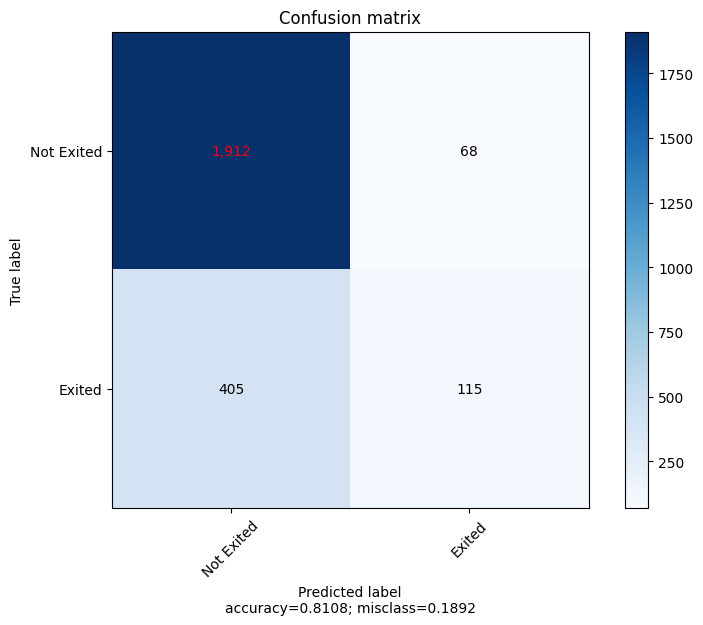

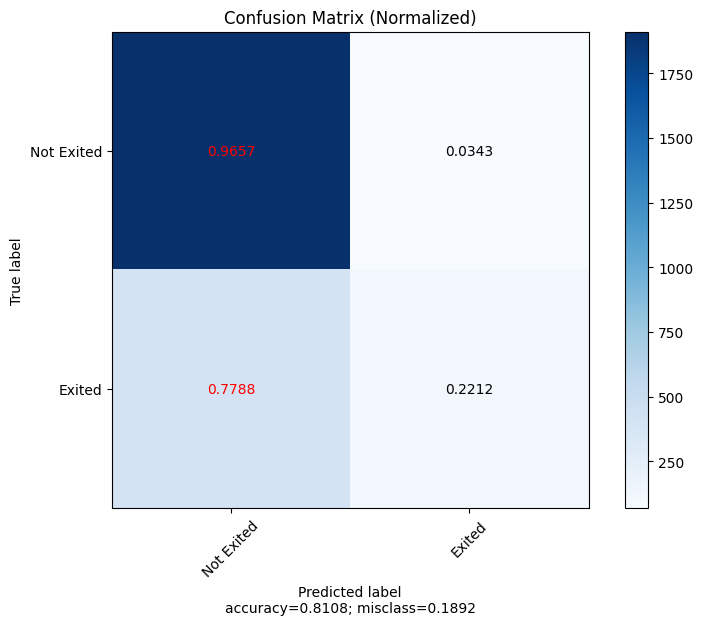

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169


In [ ]:
pred = LRmodel.predict(test[features])
predp = LRmodel.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

table_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
table_of_models

# KNN

In [ ]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
KNNmodel = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNNmodel.fit(train[features], train[target])

KNeighborsClassifier()

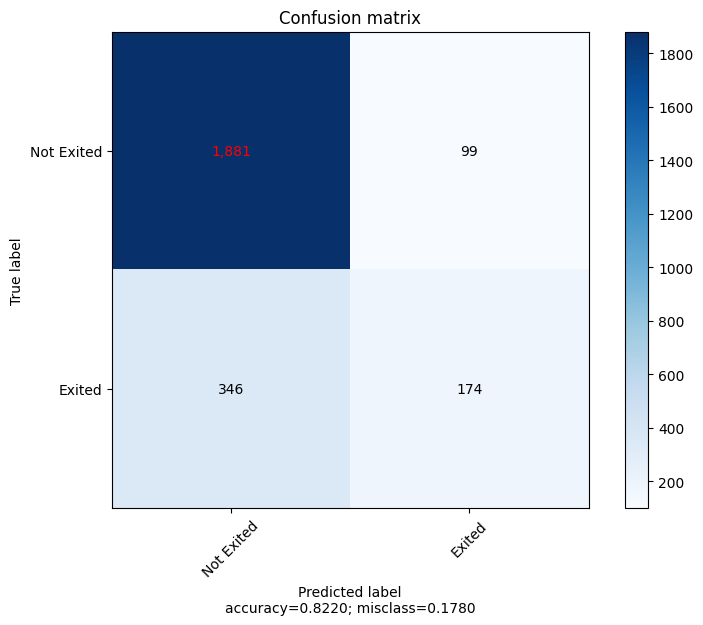

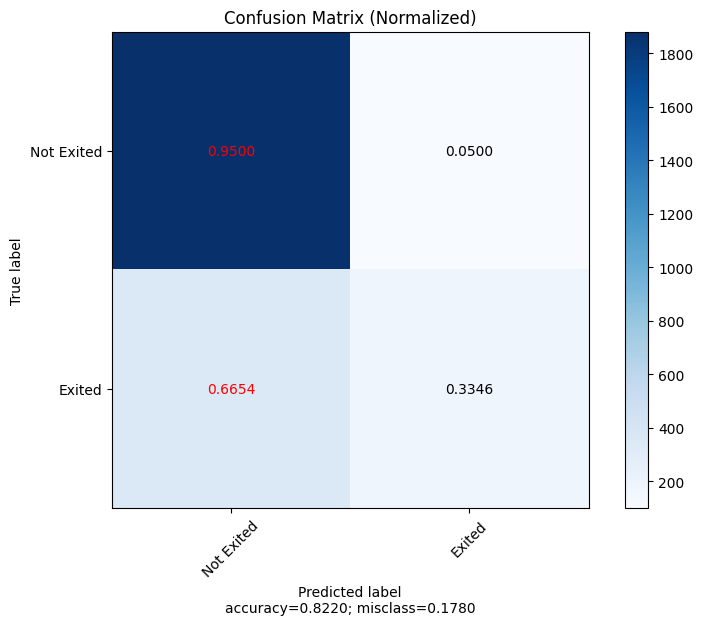

<ipython-input-20-a1b3608b4e1d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840


In [ ]:
pred = KNNmodel.predict(test[features])
predp = KNNmodel.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'K-Nearest Neighbor')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Linear SVM

In [ ]:
from sklearn.svm import SVC
LSVM = SVC(kernel = 'linear', probability=True, random_state = 0)
LSVM.fit(train[features], train[target])

SVC(kernel='linear', probability=True, random_state=0)

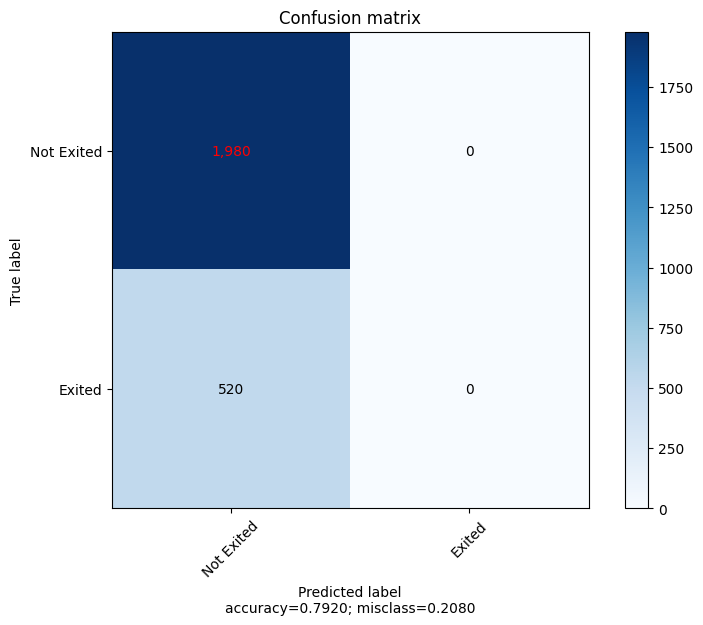

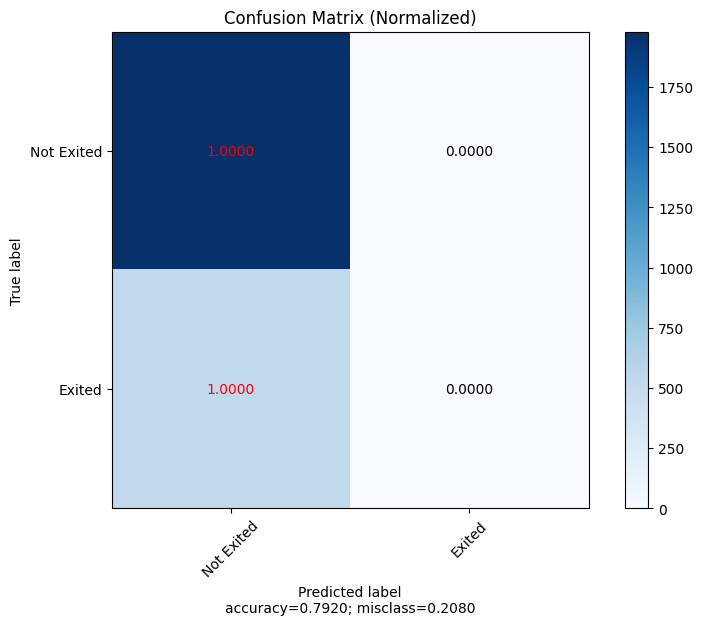

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-22-13c12458f4b8>:10: FutureWarning: The frame.app

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000


In [ ]:
pred = LSVM.predict(test[features])
predp = LSVM.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Linear SVM')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Kernel SVM

In [ ]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
KSVM = SVC(kernel = 'rbf', probability=True, random_state = 0)
KSVM.fit(train[features], train[target])

SVC(probability=True, random_state=0)

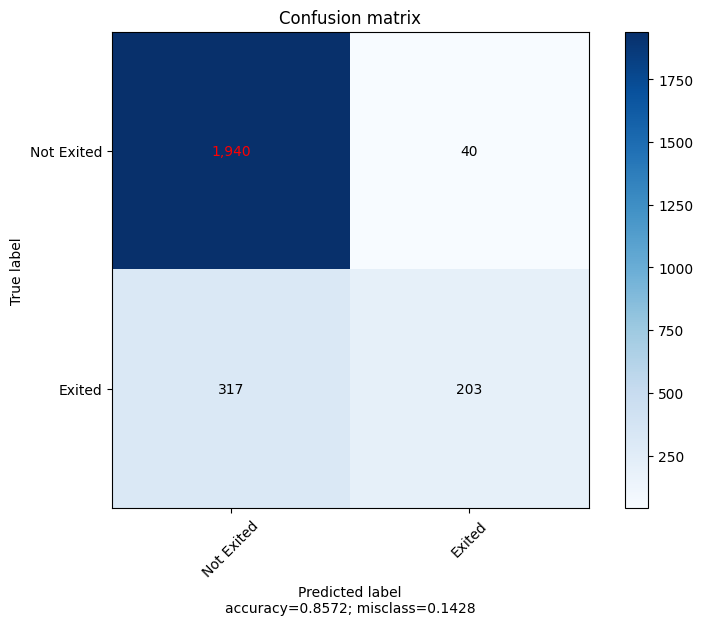

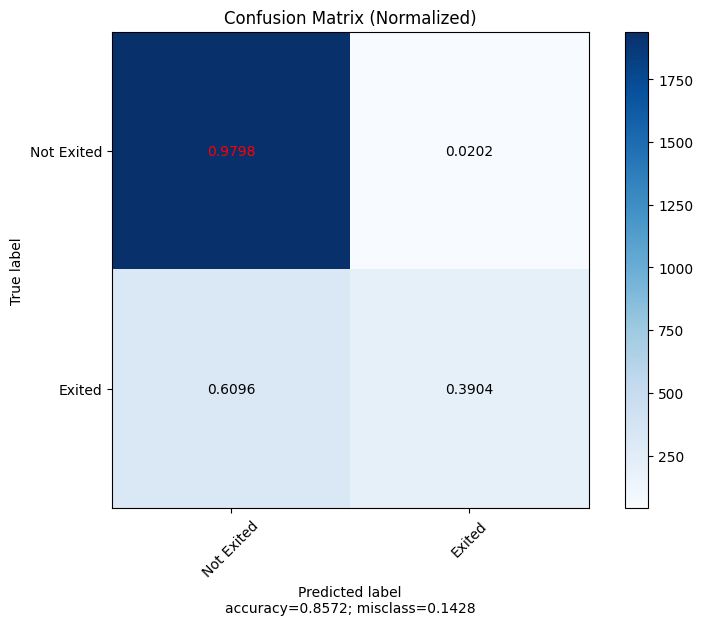

<ipython-input-24-0ba15158ad67>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110


In [ ]:
pred = KSVM.predict(test[features])
predp = KSVM.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Kernel SVM')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(train[features], train[target])

GaussianNB()

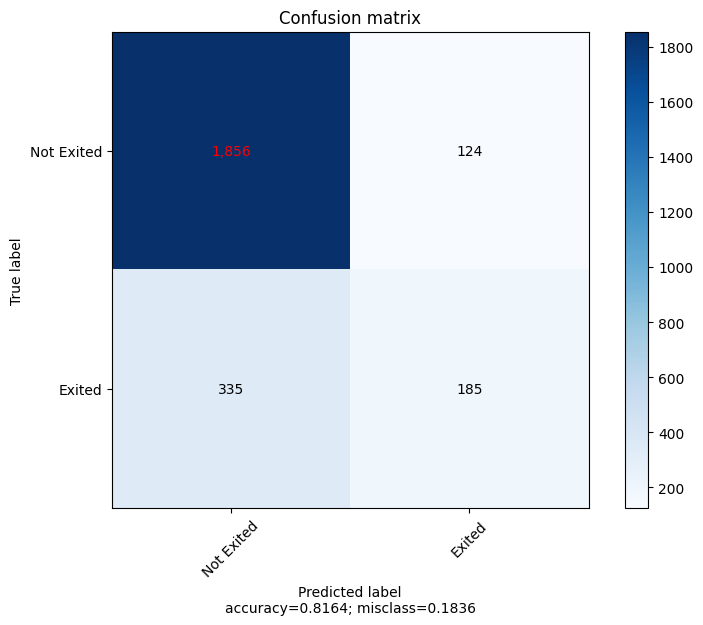

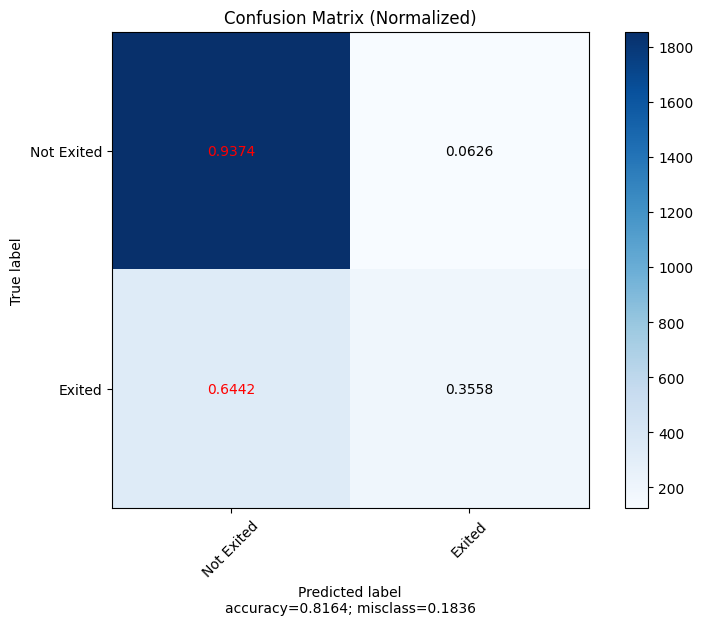

<ipython-input-26-bf3501d68ccf>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321


In [ ]:
pred = NB.predict(test[features])
predp = NB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Naive Bayes')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DT.fit(train[features], train[target])

DecisionTreeClassifier(criterion='entropy', random_state=0)

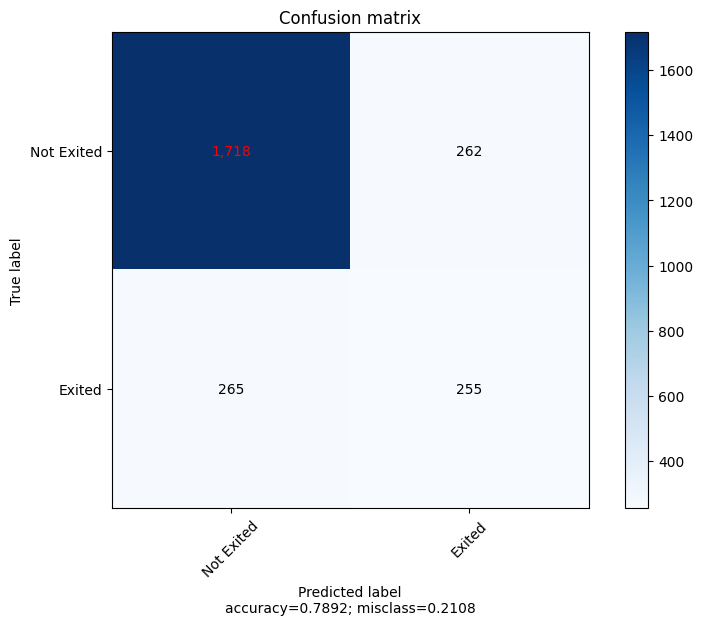

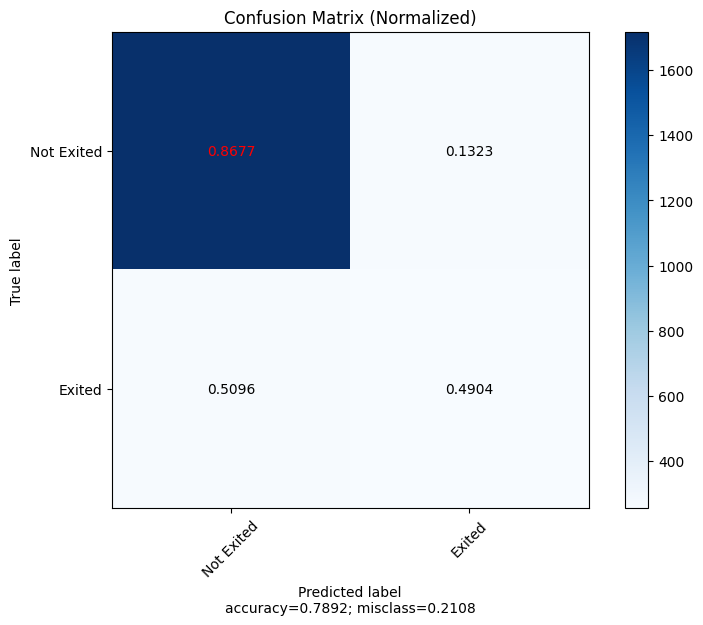

<ipython-input-28-b7b10f01c392>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803


In [ ]:
pred = DT.predict(test[features])
predp = DT.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Decision Tree')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RF.fit(train[features], train[target])

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

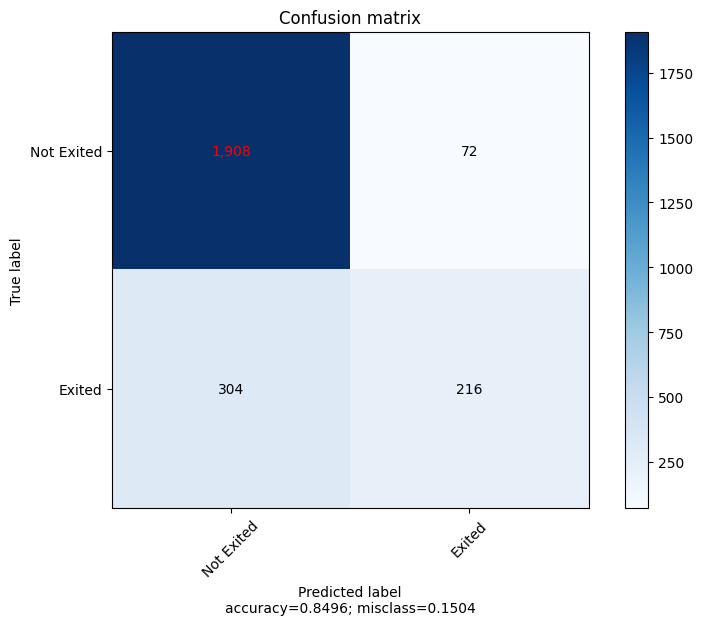

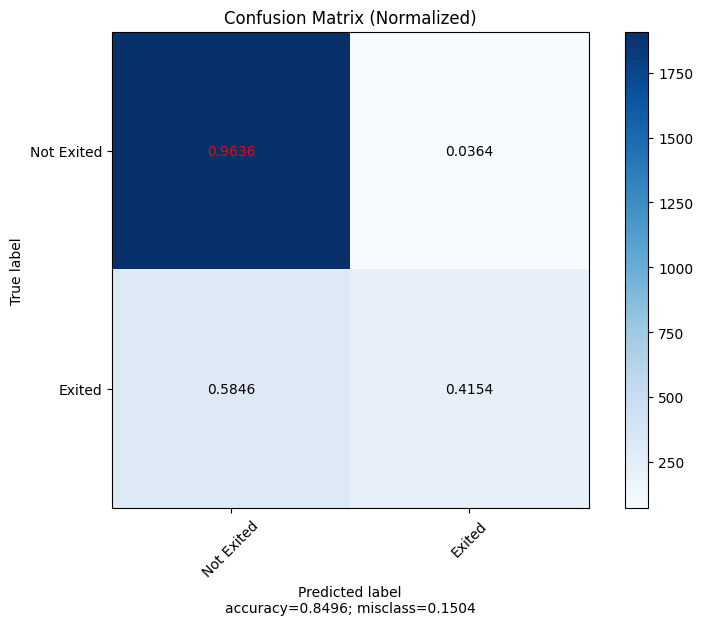

<ipython-input-30-ea779fdffe2e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653


In [ ]:
pred = RF.predict(test[features])
predp = RF.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Random Forest')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier()
GB.fit(train[features], train[target])

GradientBoostingClassifier()

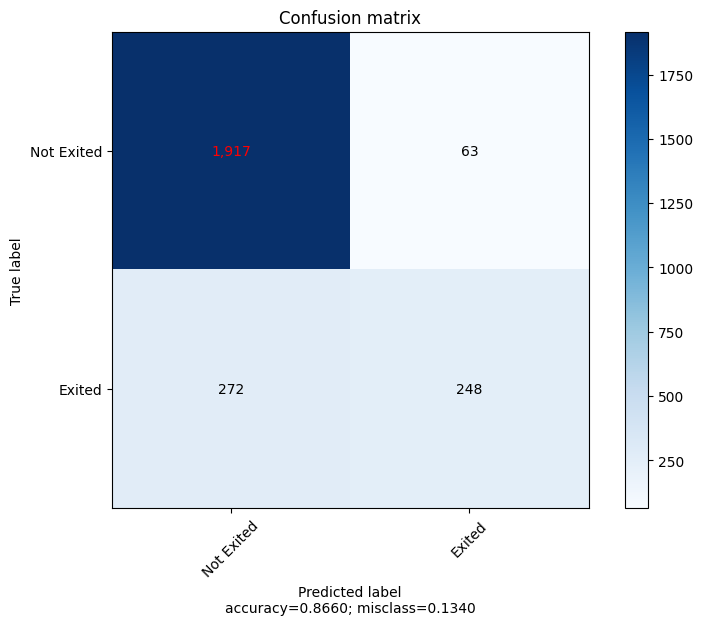

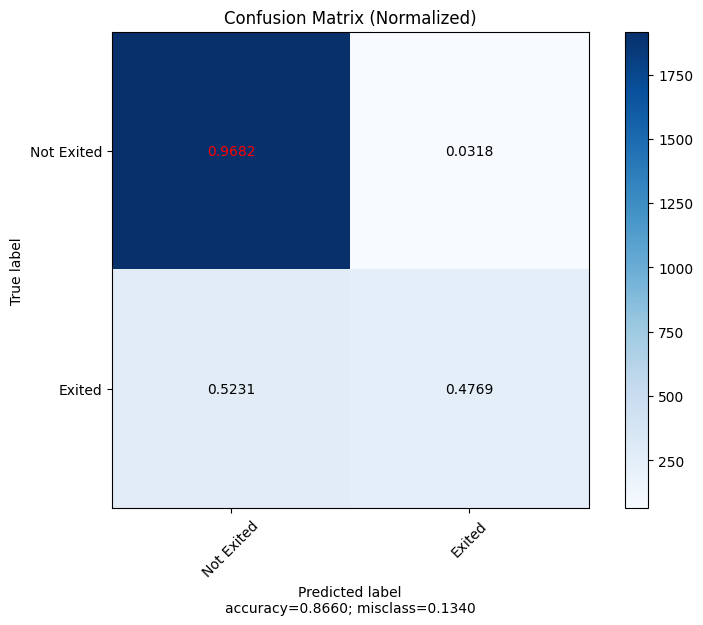

<ipython-input-32-436541bda4fd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871


In [ ]:
pred = GB.predict(test[features])
predp = GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# Ada Boosting Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
Ada.fit(train[features], train[target])

AdaBoostClassifier()

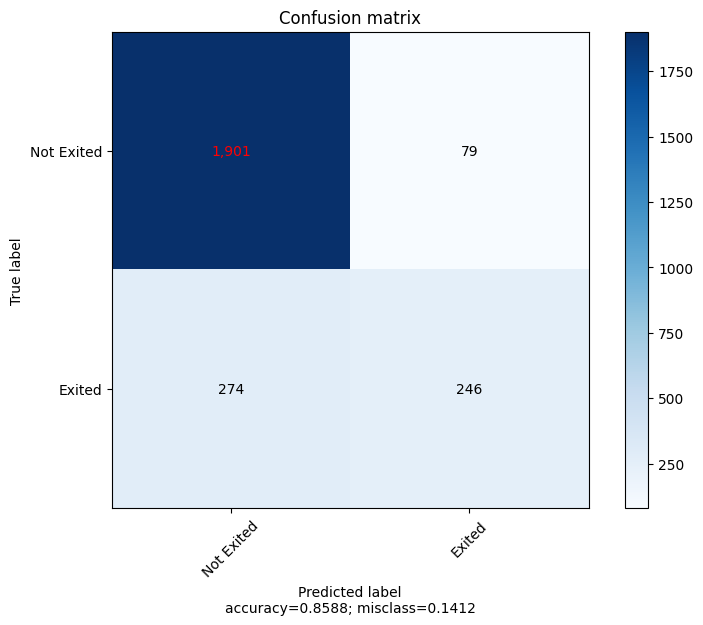

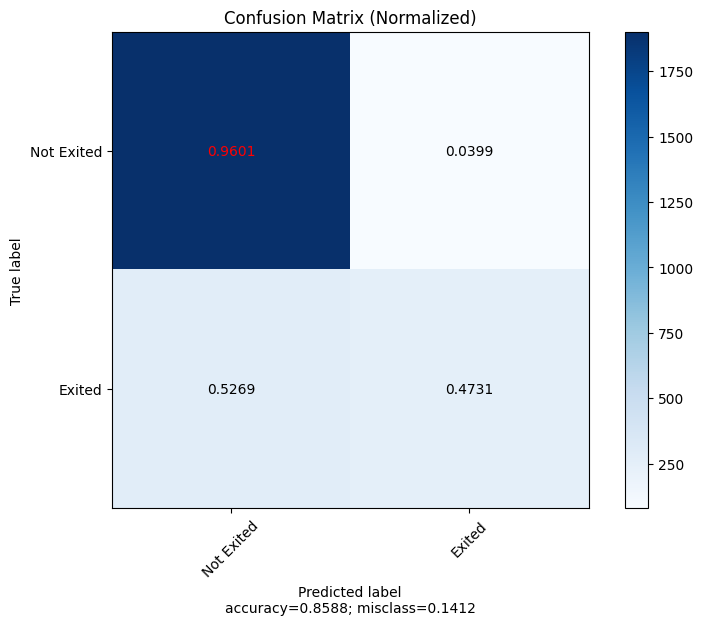

<ipython-input-34-4db2b2dddcf7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249


In [ ]:
pred = Ada.predict(test[features])
predp = Ada.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Ada Boosting')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# XGB Classifier

In [ ]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(train[features], train[target])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

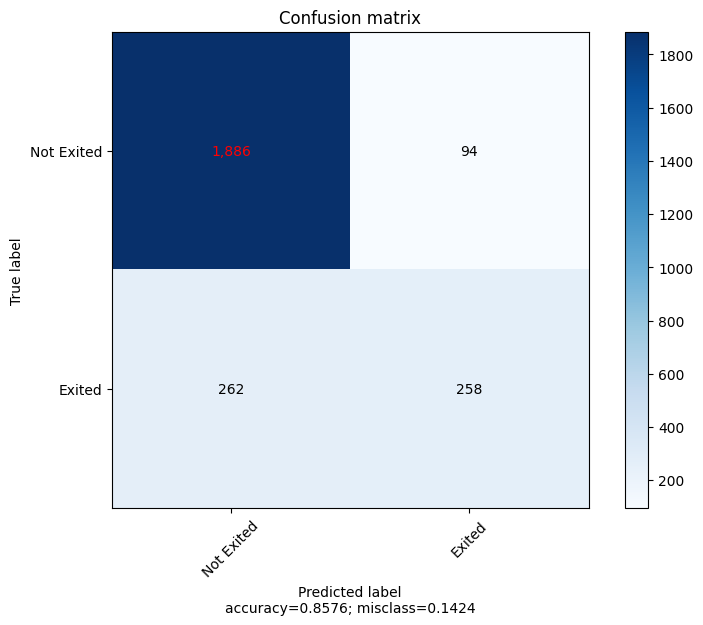

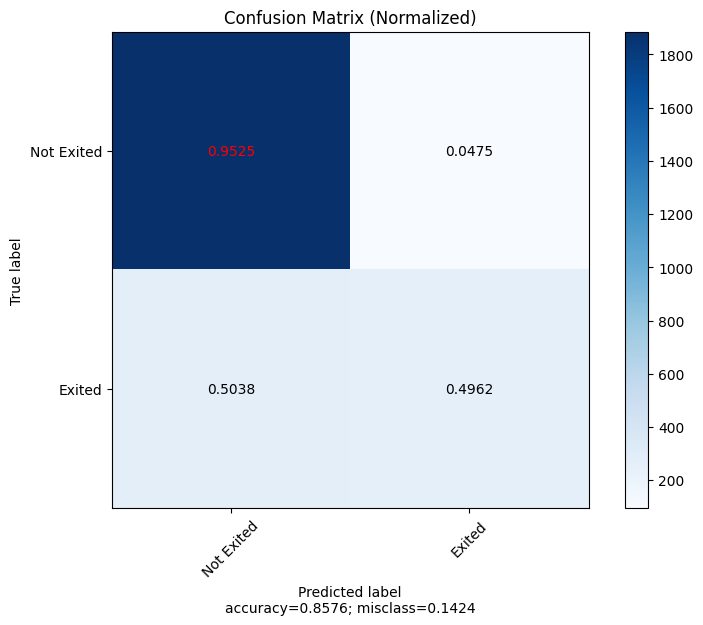

<ipython-input-36-1d0818be02c8>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249
0,XGB Classifier,no,0.8576,0.724340,0.850001,0.878026,0.952525,0.913760,0.732955,0.496154,0.591743


In [ ]:
pred = XGB.predict(test[features])
predp = XGB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'XGB Classifier')
temp
table_of_models = table_of_models.append(temp)
table_of_models

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
CB = CatBoostClassifier()
CB.fit(train[features], train[target])

Learning rate set to 0.024355
0:	learn: 0.6738214	total: 54.2ms	remaining: 54.1s
1:	learn: 0.6550727	total: 60.2ms	remaining: 30.1s
2:	learn: 0.6376513	total: 68.4ms	remaining: 22.7s
3:	learn: 0.6215445	total: 78ms	remaining: 19.4s
4:	learn: 0.6064507	total: 85.7ms	remaining: 17s
5:	learn: 0.5919049	total: 89.3ms	remaining: 14.8s
6:	learn: 0.5790086	total: 94.5ms	remaining: 13.4s
7:	learn: 0.5654620	total: 97.9ms	remaining: 12.1s
8:	learn: 0.5527773	total: 101ms	remaining: 11.2s
9:	learn: 0.5416721	total: 105ms	remaining: 10.4s
10:	learn: 0.5308305	total: 109ms	remaining: 9.81s
11:	learn: 0.5207898	total: 113ms	remaining: 9.27s
12:	learn: 0.5114681	total: 120ms	remaining: 9.11s
13:	learn: 0.5026636	total: 124ms	remaining: 8.71s
14:	learn: 0.4949555	total: 130ms	remaining: 8.57s
15:	learn: 0.4884757	total: 138ms	remaining: 8.48s
16:	learn: 0.4797445	total: 145ms	remaining: 8.37s
17:	learn: 0.4743465	total: 148ms	remaining: 8.05s
18:	learn: 0.4684310	total: 151ms	remaining: 7.79s
19:	lea

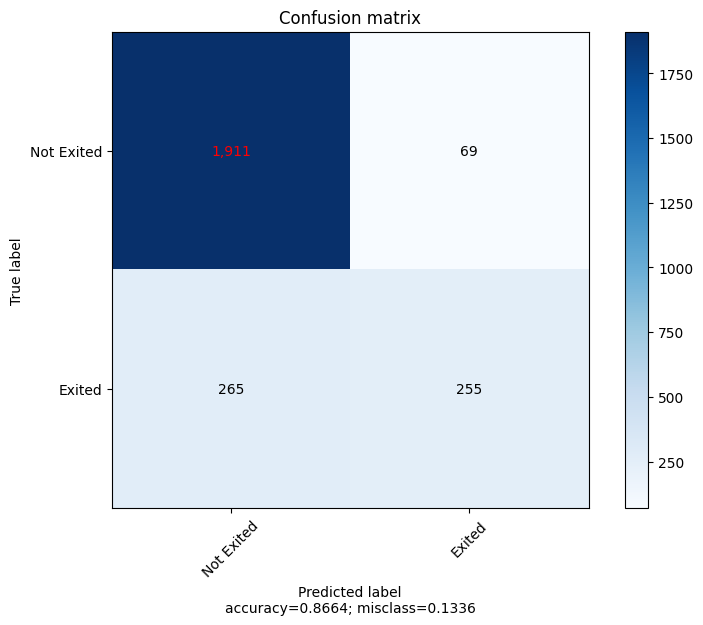

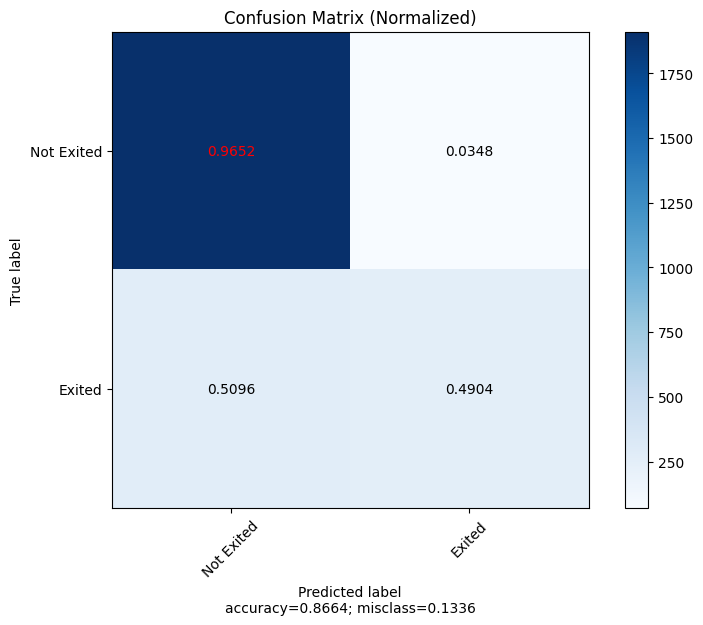

<ipython-input-39-27aa30ee67f3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249
0,XGB Classifier,no,0.8576,0.724340,0.850001,0.878026,0.952525,0.913760,0.732955,0.496154,0.591743


In [ ]:
pred = CB.predict(test[features])
predp = CB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Cat Boost Classifier')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# LDA Classifier

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(train[features], train[target])

LinearDiscriminantAnalysis()

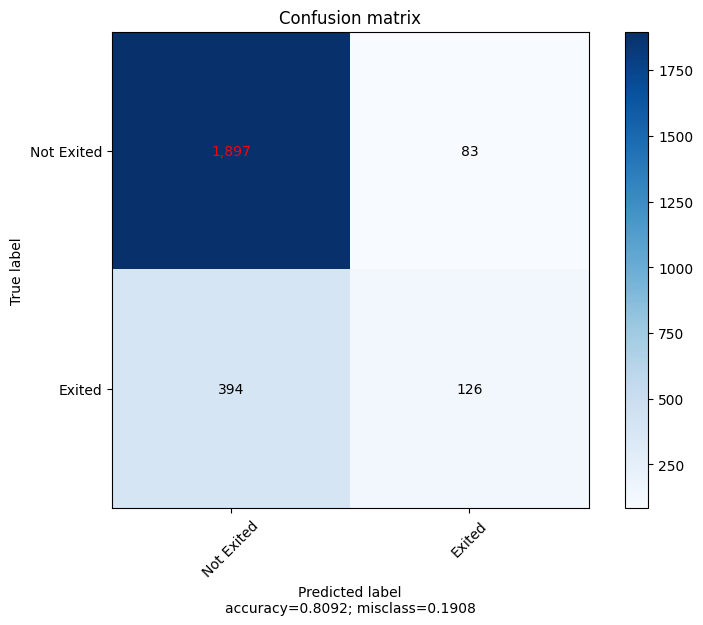

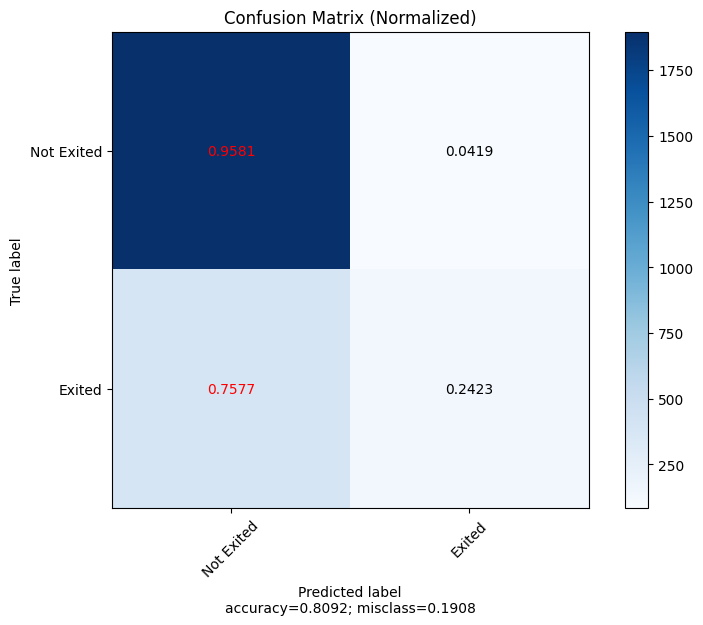

<ipython-input-41-c7f87bcc60fc>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249
0,XGB Classifier,no,0.8576,0.724340,0.850001,0.878026,0.952525,0.913760,0.732955,0.496154,0.591743


In [ ]:
pred = LDA.predict(test[features])
predp = LDA.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'LDA Classifier')
temp
table_of_models = table_of_models.append(temp)
table_of_models

In [ ]:
QDA Classifier

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(train[features], train[target])

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

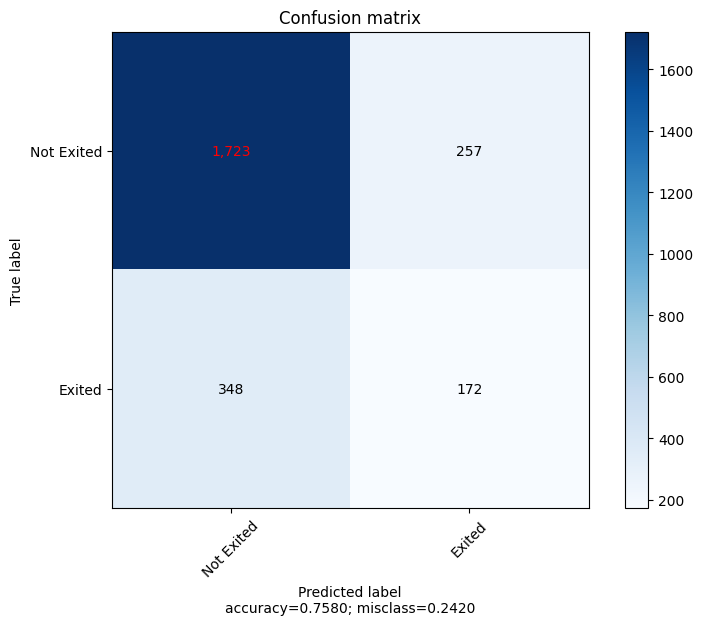

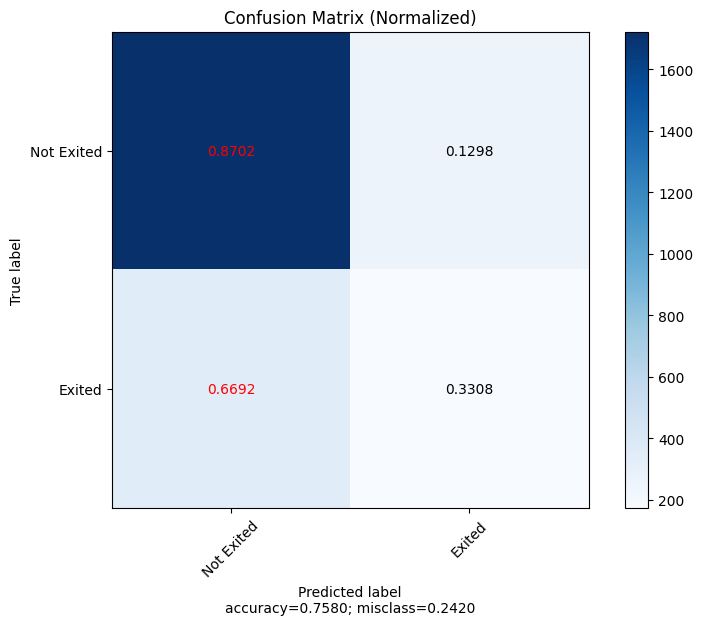

<ipython-input-43-77ccc5a074e0>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249
0,XGB Classifier,no,0.8576,0.724340,0.850001,0.878026,0.952525,0.913760,0.732955,0.496154,0.591743


In [ ]:
pred = QDA.predict(test[features])
predp = QDA.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'QDA Classifier')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
# Create a RandomForestClassifier object
ann_model = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500, random_state=42)

ann_model.fit(train[features], train[target])

MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=42)

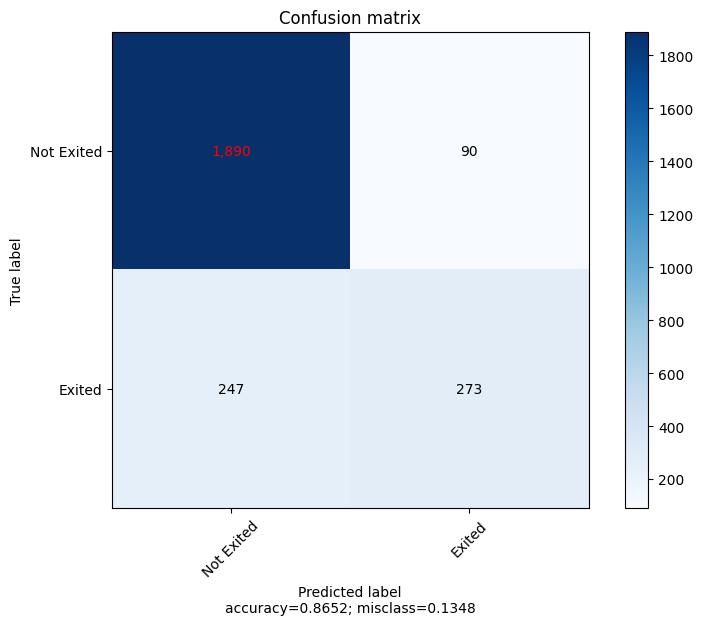

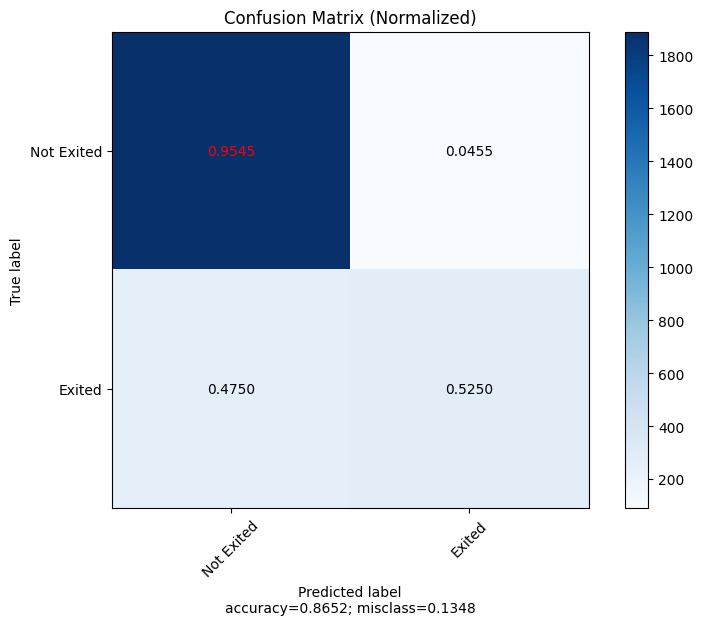

<ipython-input-47-6676999e4776>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249
0,XGB Classifier,no,0.8576,0.724340,0.850001,0.878026,0.952525,0.913760,0.732955,0.496154,0.591743


In [ ]:
pred = ann_model.predict(test[features])
predp = ann_model.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Multi Layer Perceptron')
temp
table_of_models = table_of_models.append(temp)
table_of_models

# LightGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier
LGB=LGBMClassifier()
LGB.fit(train[features], train[target])

LGBMClassifier()

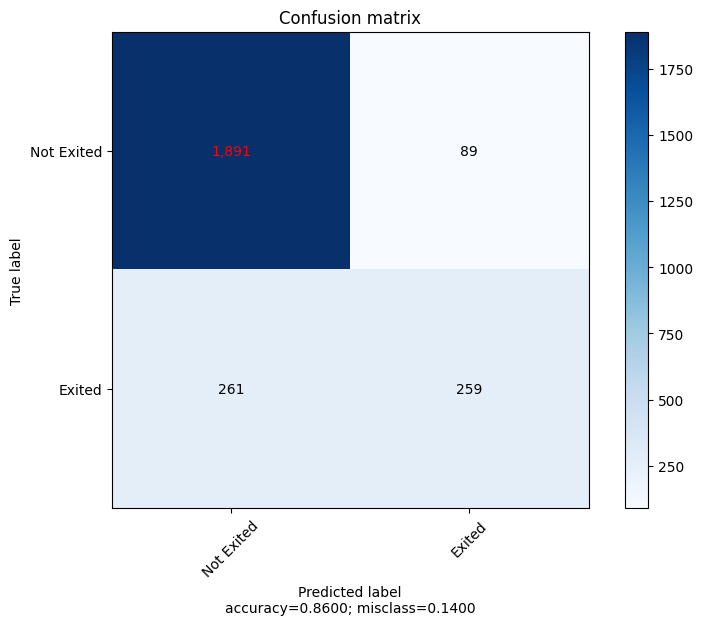

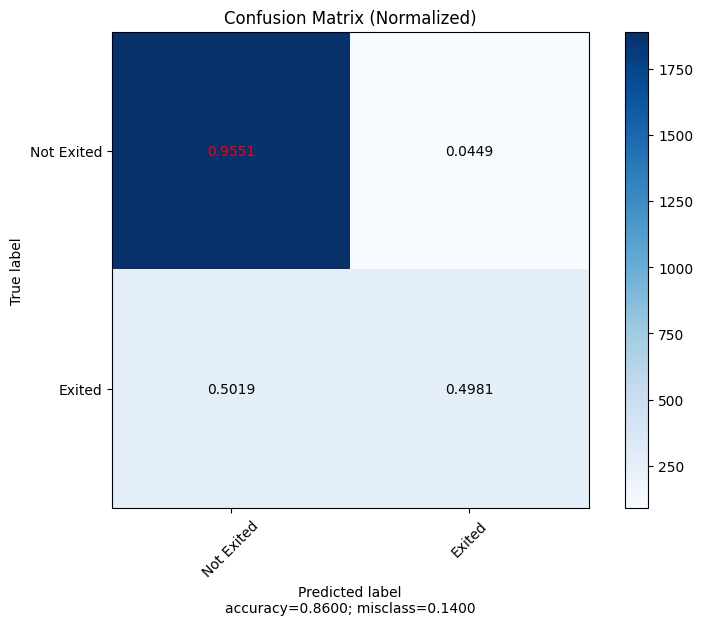

<ipython-input-49-bfb8c5f6872a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8108,0.593405,0.773665,0.825205,0.965657,0.889923,0.628415,0.221154,0.327169
0,K-Nearest Neighbor,no,0.8220,0.642308,0.761583,0.844634,0.950000,0.894224,0.637363,0.334615,0.438840
0,Linear SVM,no,0.7920,0.500000,0.735638,0.792000,1.000000,0.883929,0.000000,0.000000,0.000000
0,Kernel SVM,no,0.8572,0.685091,0.837348,0.859548,0.979798,0.915742,0.835391,0.390385,0.532110
0,Naive Bayes,no,0.8164,0.646571,0.793951,0.847102,0.937374,0.889954,0.598706,0.355769,0.446321
0,Decision Tree,no,0.7892,0.679031,0.679031,0.866364,0.867677,0.867020,0.493230,0.490385,0.491803
0,Random Forest,no,0.8496,0.689510,0.830450,0.862568,0.963636,0.910305,0.750000,0.415385,0.534653
0,Gradient Boosting,no,0.8660,0.722552,0.875121,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Ada Boosting,no,0.8588,0.716589,0.859242,0.874023,0.960101,0.915042,0.756923,0.473077,0.582249
0,XGB Classifier,no,0.8576,0.724340,0.850001,0.878026,0.952525,0.913760,0.732955,0.496154,0.591743


In [ ]:
pred = LGB.predict(test[features])
predp = LGB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'LGBM Classifier')
temp
table_of_models = table_of_models.append(temp)
table_of_models

#### 2.4.1 Logistic Regression (Sklearn)

For the first prediction, let's use the [Sklearn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) searching for the best parameters using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function:

In [ ]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.138305,0.040481,0.014876,0.006100,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
1,0.100818,0.020224,0.019217,0.004889,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
2,0.081556,0.004944,0.018404,0.004961,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.814667,0.817333,0.803333,0.806000,0.809333,0.810133,0.005222,58
3,0.231075,0.023082,0.019373,0.004065,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
4,0.275988,0.015423,0.022543,0.007352,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
5,0.186130,0.019202,0.018344,0.005692,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
6,0.082031,0.009273,0.018060,0.008308,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
7,0.090006,0.007660,0.017579,0.004135,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.814667,0.817333,0.803333,0.806000,0.809333,0.810133,0.005222,58
8,0.254318,0.024648,0.020320,0.009850,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1
9,0.312445,0.063763,0.021320,0.003625,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.815333,0.820000,0.804667,0.808667,0.810000,0.811733,0.005360,1


In [ ]:
print(model_LR.best_params_)

{'C': 0.01, 'max_iter': 50, 'solver': 'newton-cg'}


Now that we know the "best" parameters for the model, let's do a *Recursive Feature Elimination* to check the feature importance.

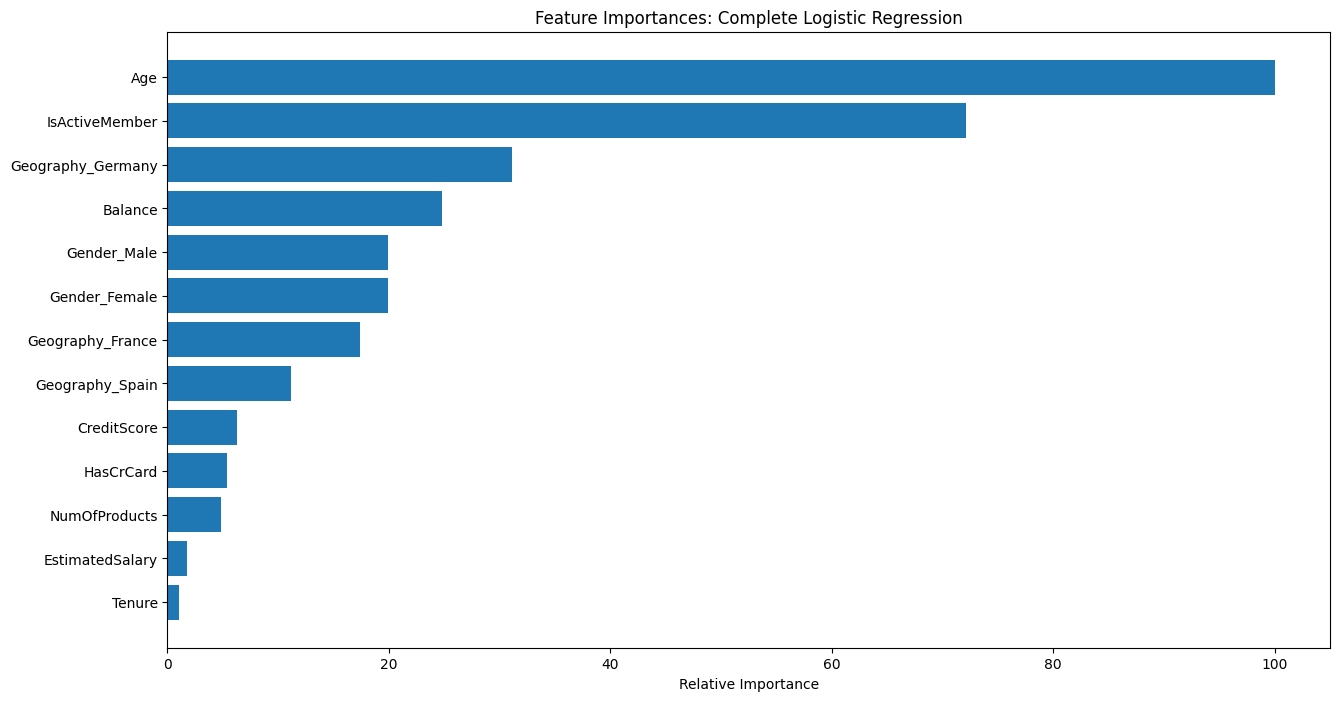

In [ ]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(train[features], train[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, let's compute the predictions for the best set of parameters:

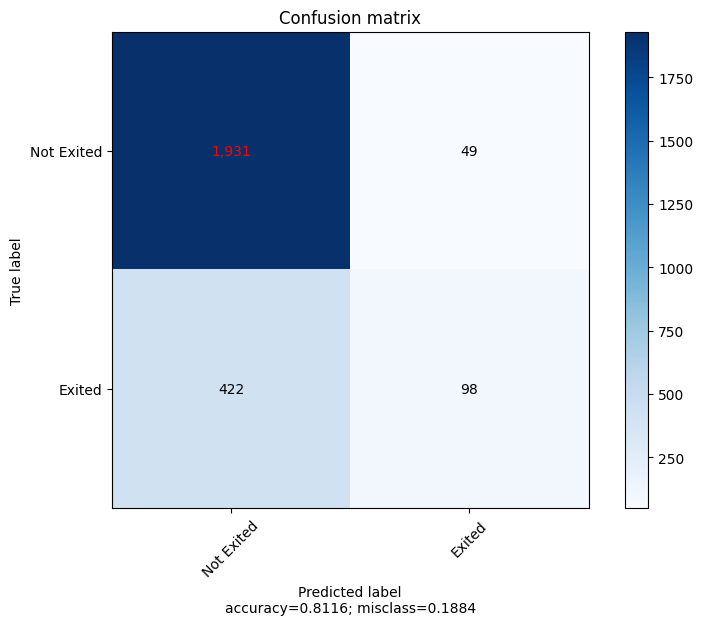

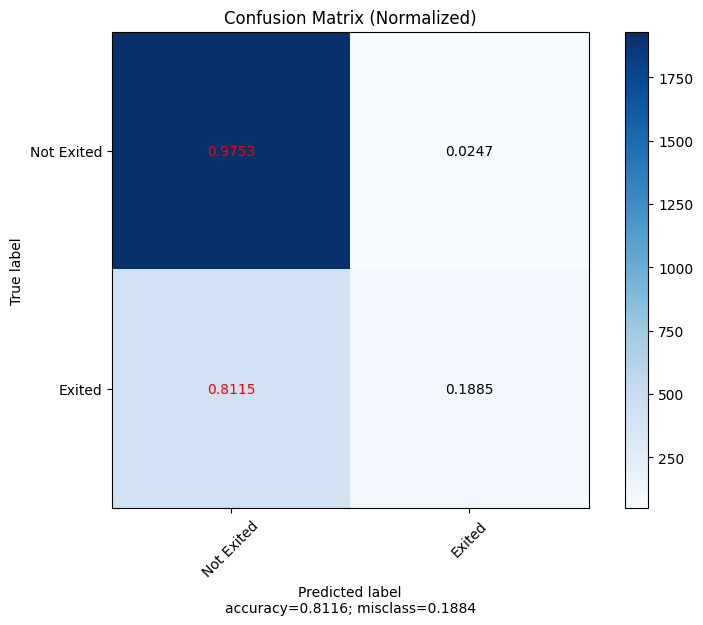

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853


In [ ]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

table_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
table_of_models

#### 2.4.2 MLP: Multi Layers Perceptron

Now, let's enter in the `Neural Networks` domain, by doing predictions using the [Sklear Multi-Layer Perceptron (MLP) Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

In [ ]:
s = len(features)
parameters = {'hidden_layer_sizes': [(s,),
                                     (s,)*2,
                                     (s,)*4,
                                     (s,)*6],
              'solver': ['lbfgs', 'adam'],
              'alpha': [0, 0.01, 0.1, 1, 10]}
MLP = MLPClassifier()
model_MLP = GridSearchCV(MLP, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_MLP.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.009091,0.404505,0.025670,0.012064,0,"(13,)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13,), 'sol...",0.862000,0.843333,0.848000,0.850000,0.844000,0.849467,0.006738,21
1,26.697753,2.436004,0.028778,0.007832,0,"(13,)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13,), 'sol...",0.862000,0.862000,0.853333,0.852000,0.852667,0.856400,0.004592,9
2,10.700490,0.158749,0.017359,0.002670,0,"(13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13), '...",0.854000,0.844667,0.848000,0.853333,0.838000,0.847600,0.005912,24
3,37.836363,2.401556,0.032705,0.012807,0,"(13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13), '...",0.854667,0.852667,0.848000,0.857333,0.852000,0.852933,0.003087,14
4,17.505396,0.274111,0.026403,0.011120,0,"(13, 13, 13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.849333,0.838000,0.842667,0.828667,0.844667,0.840667,0.007017,36
5,58.733869,0.126151,0.024505,0.008079,0,"(13, 13, 13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.849333,0.836000,0.846667,0.850000,0.842000,0.844800,0.005222,32
6,24.663651,0.476794,0.030611,0.007393,0,"(13, 13, 13, 13, 13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.848000,0.844667,0.836667,0.846667,0.841333,0.843467,0.004075,34
7,81.165435,0.901148,0.043332,0.016544,0,"(13, 13, 13, 13, 13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.851333,0.843333,0.838000,0.842000,0.848667,0.844667,0.004770,33
8,6.626515,0.683667,0.023477,0.007550,0.01,"(13,)",lbfgs,"{'alpha': 0.01, 'hidden_layer_sizes': (13,), '...",0.860000,0.852000,0.848000,0.856000,0.844667,0.852133,0.005472,16
9,26.447945,3.214733,0.027638,0.013962,0.01,"(13,)",adam,"{'alpha': 0.01, 'hidden_layer_sizes': (13,), '...",0.861333,0.862000,0.852000,0.862667,0.848000,0.857200,0.006028,4


In [ ]:
print(model_MLP.best_params_)

{'alpha': 1, 'hidden_layer_sizes': (13, 13), 'solver': 'adam'}


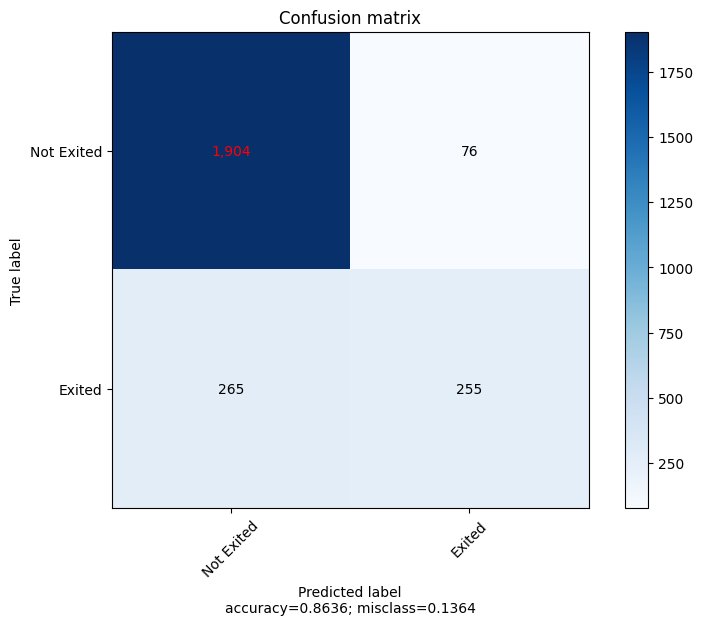

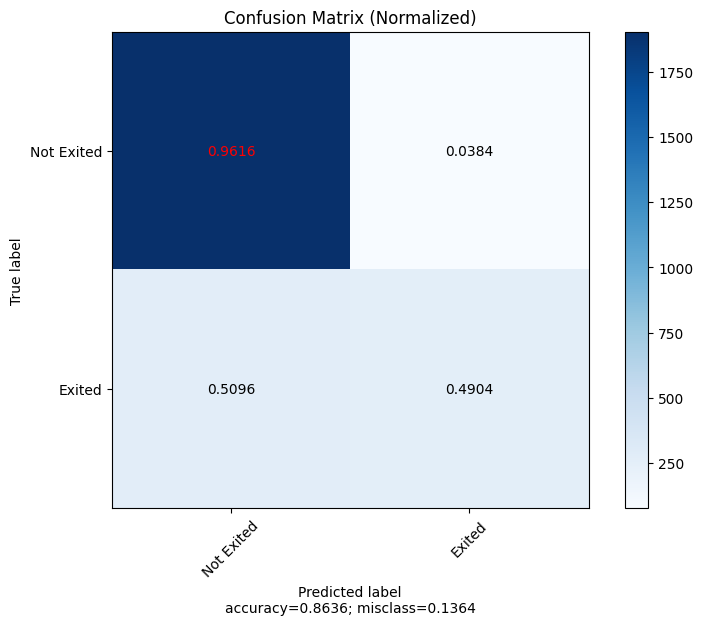

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295


In [ ]:
pred = model_MLP.predict(test[features])
predp = model_MLP.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Multi-Layer Perceptron (MLP)')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

<ipython-input-57-c1cad58f660f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295


#### 2.4.3 Gradient Boosting Classifier (Sklearn)

Now, let's use the [Sklearn Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) algorithm for the predictions.

In [ ]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.428384,0.200848,0.029755,0.008576,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.866667,0.852000,0.852667,0.859333,0.850667,0.856267,0.006001,13
1,5.616217,0.085936,0.069379,0.006125,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.872000,0.854000,0.854667,0.863333,0.857333,0.860267,0.006728,9
2,17.260789,0.232300,0.061610,0.016205,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.874667,0.856000,0.863333,0.866667,0.856667,0.863467,0.006895,2
3,30.610557,0.792899,0.146706,0.019089,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.874000,0.853333,0.862667,0.860000,0.855333,0.861067,0.007261,6
4,4.486684,0.296799,0.058195,0.009914,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.872000,0.859333,0.859333,0.864667,0.852000,0.861467,0.006632,5
5,8.226127,0.393056,0.040582,0.006136,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.878000,0.860000,0.862000,0.865333,0.852667,0.863600,0.008312,1
6,25.640636,0.293496,0.075486,0.012136,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.875333,0.861333,0.863333,0.858667,0.854000,0.862533,0.007123,4
7,41.457531,0.571129,0.136435,0.041230,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.871333,0.855333,0.858667,0.857333,0.856000,0.859733,0.005912,11
8,4.682630,0.174801,0.033754,0.003543,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.873333,0.854667,0.860000,0.861333,0.848667,0.859600,0.008193,12
9,11.421238,0.083859,0.052756,0.004682,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.874000,0.860667,0.865333,0.864000,0.852667,0.863333,0.006915,3


In [ ]:
print(model_GB.best_params_)

{'max_depth': 3, 'n_estimators': 100}


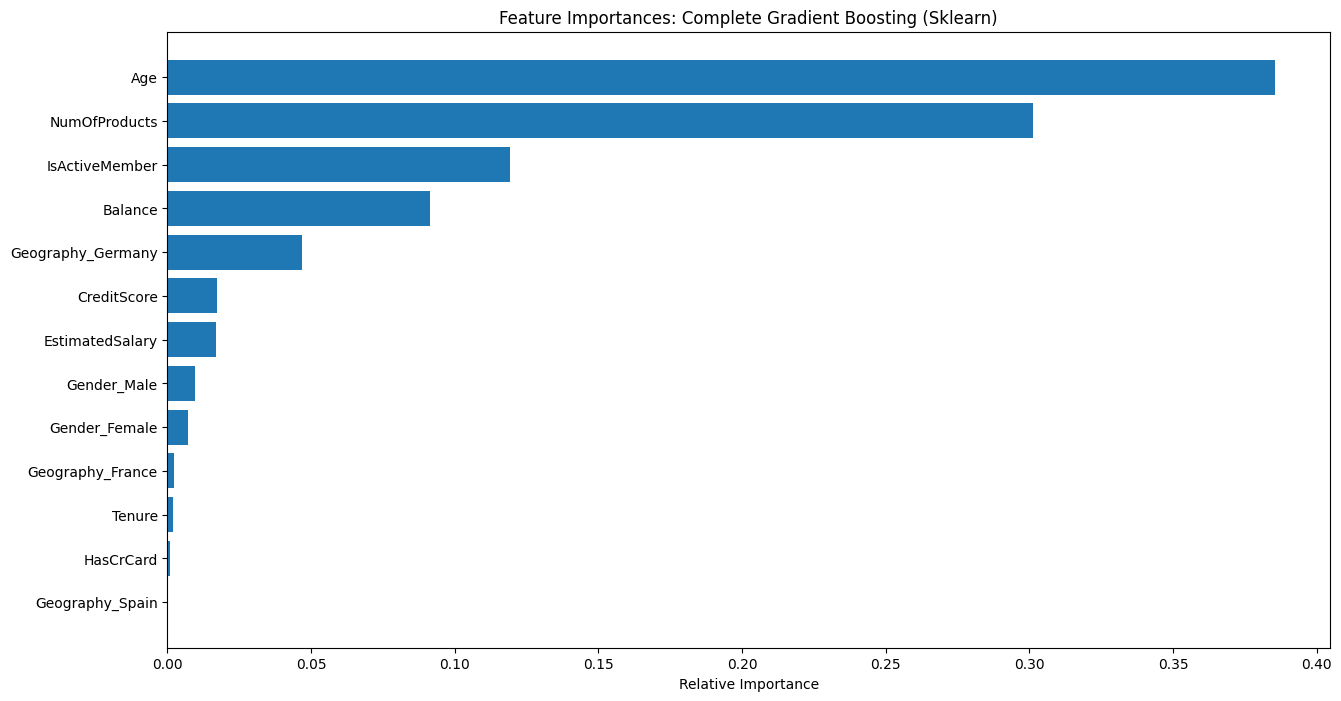

In [ ]:
model = GBSklearn(**model_GB.best_params_)
model.fit(train[features], train[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

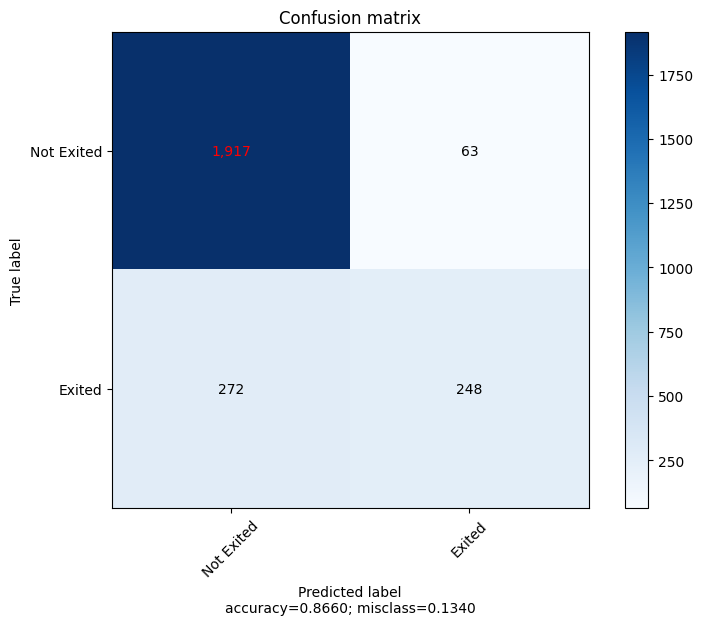

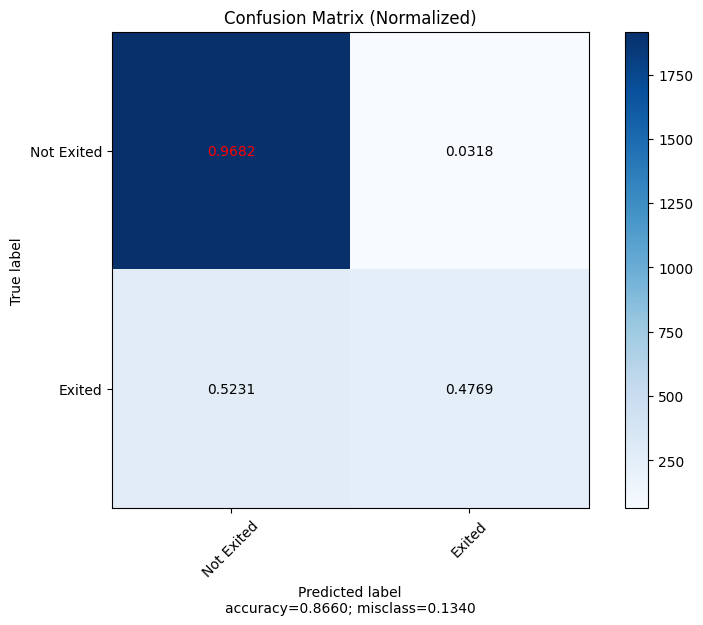

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),no,0.866,0.722552,0.875206,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871


In [ ]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

<ipython-input-68-c1cad58f660f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Multi-Layer Perceptron (MLP),yes,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Gradient Boosting (Sklearn),no,0.8660,0.722552,0.875206,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871


#### 2.4.4 Extreme Gradient Boosting (XGBoost)

Let's get out of the `Scikit-learn` for now and try the package [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

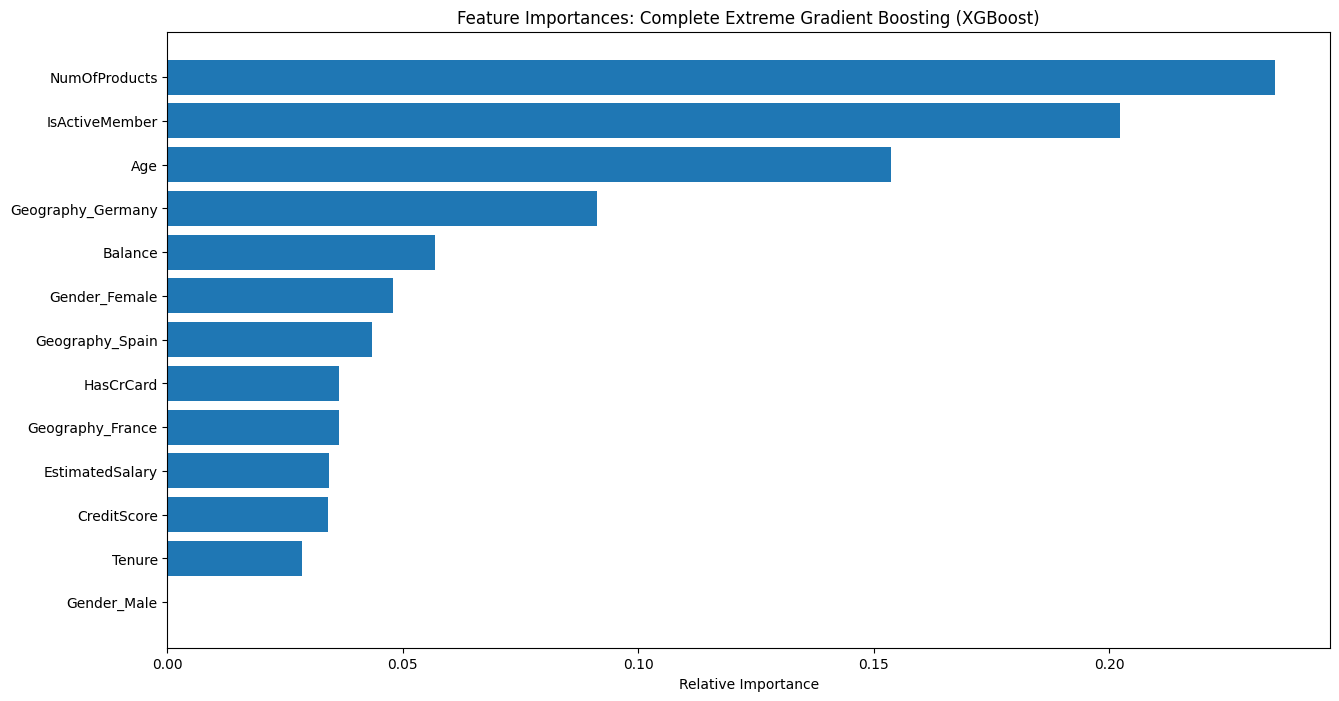

In [ ]:
model_XGB = XGBClassifier(max_depth = 6,
            learning_rate = .1,
            n_estimators = 100,
            reg_lambda = 0.5,
            reg_alpha = 0,
            verbosity = 1,
            n_jobs = -1,).fit(train[features], train[target])

pred = model_XGB.predict(test[features])
predp = model_XGB.predict_proba(test[features])[:,1]

importances = model_XGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

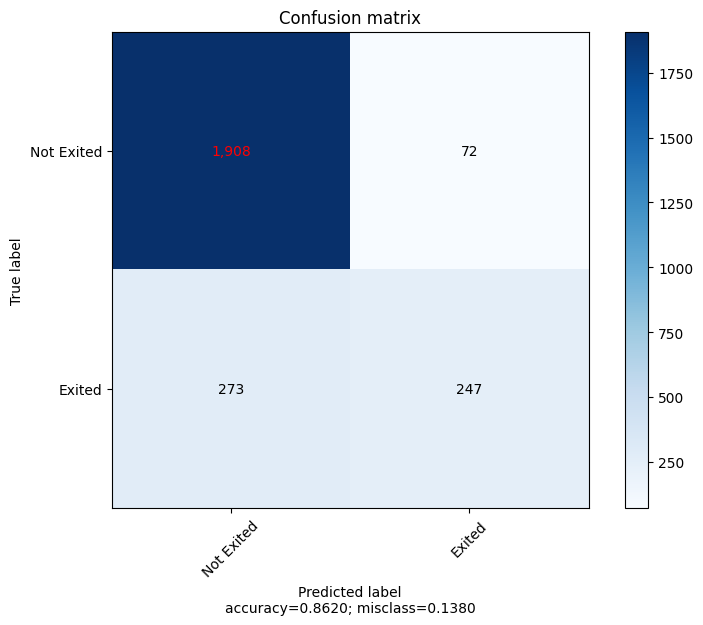

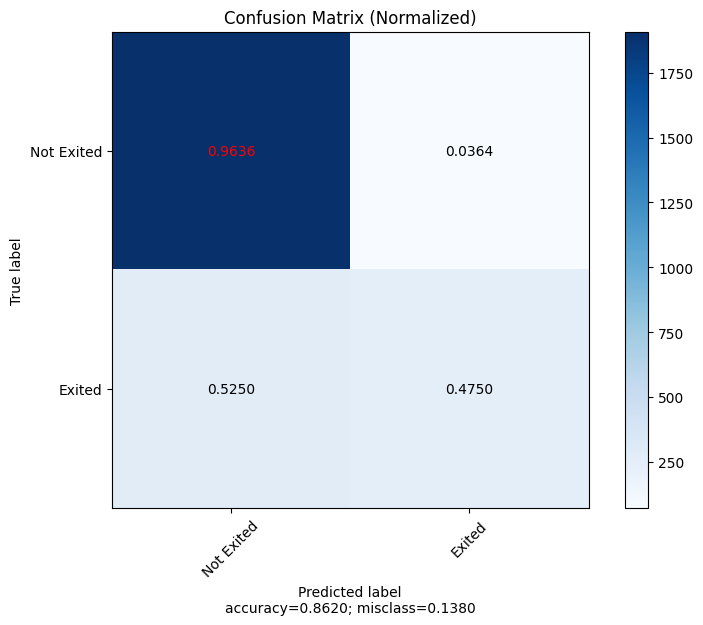

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (XGBoost),no,0.862,0.719318,0.869404,0.874828,0.963636,0.917087,0.774295,0.475,0.588796


In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (XGBoost)')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

<ipython-input-74-c1cad58f660f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Multi-Layer Perceptron (MLP),yes,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Gradient Boosting (Sklearn),no,0.8660,0.722552,0.875206,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Gradient Boosting (XGBoost),no,0.8620,0.719318,0.869404,0.874828,0.963636,0.917087,0.774295,0.475000,0.588796


#### 2.4.5 Light Gradient Boosting Machine (LightGBM)

Now, another gradient boosting algorithm, from the package [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html).

In [ ]:
train_data = lgb.Dataset(train[features],
                         label = train[target],
                         feature_name = features)
test_data = lgb.Dataset(test[features + [target]],
                              reference = train_data)

In [ ]:
param = {'num_leaves': 21,
         'num_trees': 100,
         # 'max_depth': 20,
         'objective': 'binary',
         # 'boosting': 'dart',
         'lambda_l1': 1,
         'lambda_l2': 1,
         'learning_rate': 0.1,
         'metric': ['binary_logloss', 'binary_error'],
         'seed': 1}

num_round = 10
model_LGB = lgb.train(param, train_data, num_round, valid_sets=[test_data])

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1517, number of negative: 5983
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202267 -> initscore=-1.372187
[LightGBM] [Info] Start training from score -1.372187
[1]	valid_0's binary_logloss: 0.227575	valid_0's binary_error: 0
[2]	valid_0's binary_logloss: 0.229444	valid_0's binary_error: 0
[3]	valid_0's binary_logloss: 0.231613	valid_0's binary_error: 0
[4]	valid_0's binary_logloss: 0.234149	valid_0's binary_error: 0
[5]	valid_0's binary_logloss: 0.237069	valid_0's binary_error: 0
[6]	valid_0's binary_logloss: 0.239884	valid_0's binary_error: 0.0452
[7]	valid_0's binary_logloss: 0.242842	valid_0's

<Axes: title={'center': 'Feature Importances: Complete Light Gradient Boosting Machine (LightGBM)'}, xlabel='Feature importance'>

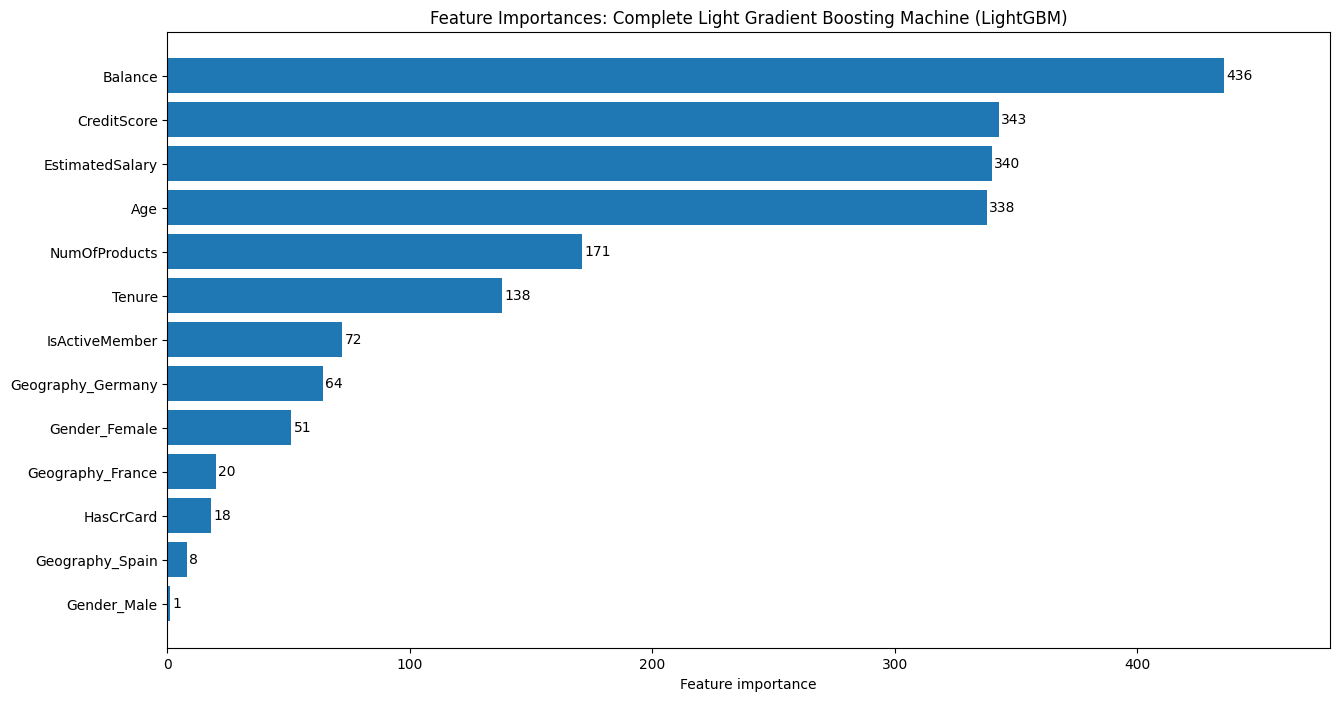

In [ ]:
predp = model_LGB.predict(test[features])
pred = predp > 0.5

lgb.plot_importance(model_LGB,
                    figsize = (15,8),
                    height = 0.8,
                    title = 'Feature Importances: Complete Light Gradient Boosting Machine (LightGBM)',
                    ylabel = None,
                    grid = False)

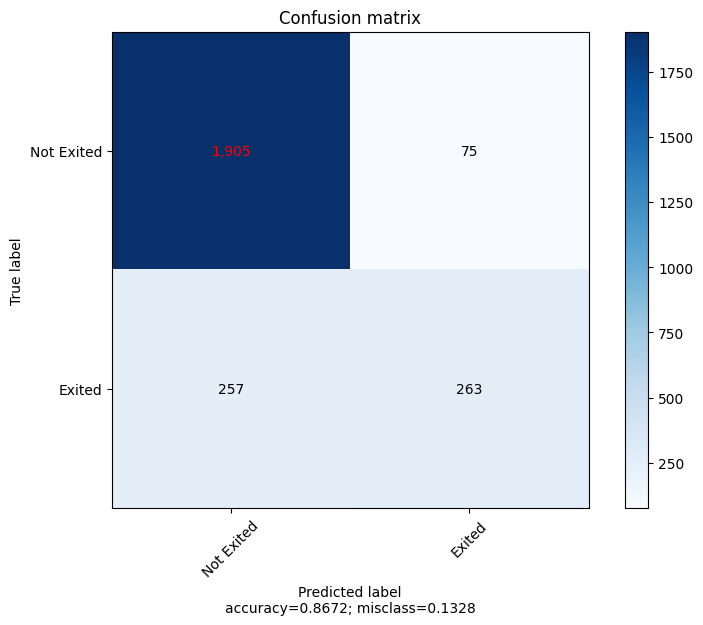

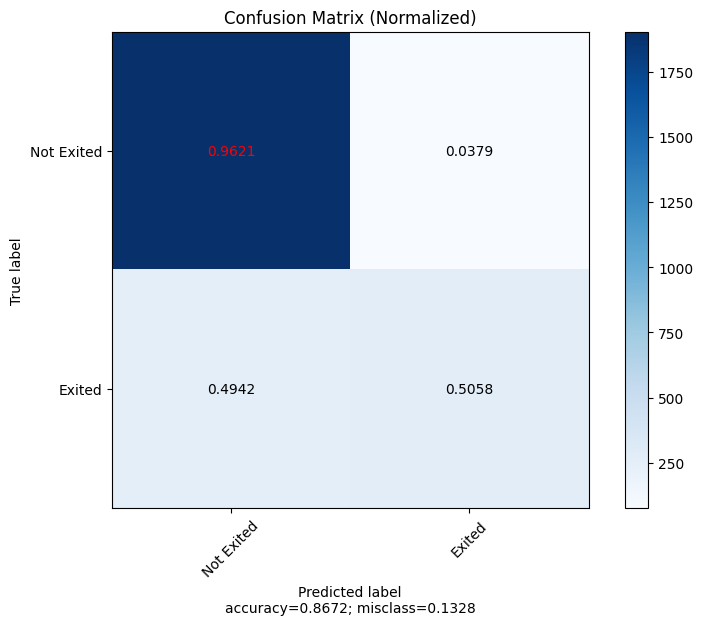

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (LightGBM),no,0.8672,0.733945,0.874539,0.881129,0.962121,0.919845,0.778107,0.505769,0.613054


In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (LightGBM)')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

<ipython-input-79-c1cad58f660f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Multi-Layer Perceptron (MLP),yes,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Gradient Boosting (Sklearn),no,0.8660,0.722552,0.875206,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Gradient Boosting (XGBoost),no,0.8620,0.719318,0.869404,0.874828,0.963636,0.917087,0.774295,0.475000,0.588796
0,Gradient Boosting (LightGBM),no,0.8672,0.733945,0.874539,0.881129,0.962121,0.919845,0.778107,0.505769,0.613054


# Balanced dataset Creation using SMOTE

In [ ]:
pip install imbalanced-learn

In [ ]:
pip install imblearn

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.10.1


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dataset1 = pd.read_csv('churn.csv')

In [ ]:
# One-Hot encoding our categorical attributes
list_cat = ['Geography', 'Gender']
dataset1 = pd.get_dummies(dataset1, columns = list_cat, prefix = list_cat)
dataset1.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


## 2.5 Balanced Training Set

Balanced accuracy improved by introducing sampling techniques. One solution to this problem is to remove data from the larger class at random intervals until the number in the smaller class equals the number in the larger class, so 50% is 0 and 50% is 1.
In this study, we only perform this balancing on the train set in order to prevent bias in the trained model while leaving the test data alone.
The best contributing six classifiers are identified from the first phase and the parameters of the classifiers are fine-tuned and tested for performance.  

The *resample_data* function will balance the data for us.

In [ ]:
def resample_data(data, target):
    data_1 = data[data[target] == 1]
    data_0 = data[data[target] == 0]
    percentage = len(data_1)/len(data_0)
    temp = data_0.sample(frac = percentage, random_state = 1)

    data_new = data_1.append(temp)
    data_new.sort_index(inplace = True)
    return data_new

In [ ]:
trainB = resample_data(train, target = target)
print('Number of clients in the dataset is : {}'.format(len(dataset)))
print('Number of clients in the balanced train set is : {}'.format(len(trainB)))
print('Number of clients in the test set is : {}'.format(len(test)))

Number of clients in the dataset is : 10000
Number of clients in the balanced train set is : 3034
Number of clients in the test set is : 2500


<ipython-input-86-9c56a9cad4de>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_1.append(temp)


In [ ]:
exited_trainB = len(trainB[trainB['Exited'] == 1]['Exited'])
exited_trainB_perc = round(exited_trainB/len(trainB)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Balanced Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_trainB, exited_trainB_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

Balanced Train set - Number of clients that have exited the program: 1517 (50.0%)
Test set - Number of clients that haven't exited the program: 520 (20.8%)


#### 2.5.1 Logistic Regresstion

In [ ]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.111046,0.014446,0.024850,0.021405,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50
1,0.135035,0.042084,0.045832,0.017191,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50
2,0.053130,0.004421,0.017745,0.006971,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.724876,0.698517,0.711697,0.682043,0.683168,0.700060,0.016514,4
3,0.149176,0.019030,0.025266,0.008846,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50
4,0.160117,0.058212,0.022349,0.007756,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50
5,0.104075,0.047475,0.016515,0.011977,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50
6,0.073728,0.003888,0.021162,0.006547,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50
7,0.053885,0.010810,0.025095,0.017046,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.724876,0.698517,0.711697,0.682043,0.683168,0.700060,0.016514,4
8,0.118430,0.010576,0.017045,0.003353,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.719934,0.703460,0.705107,0.678748,0.681518,0.697753,0.015514,49
9,0.134258,0.015054,0.034222,0.013806,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.719934,0.703460,0.705107,0.678748,0.679868,0.697423,0.015869,50


In [ ]:
print(model_LR.best_params_)

{'C': 0.1, 'max_iter': 50, 'solver': 'liblinear'}


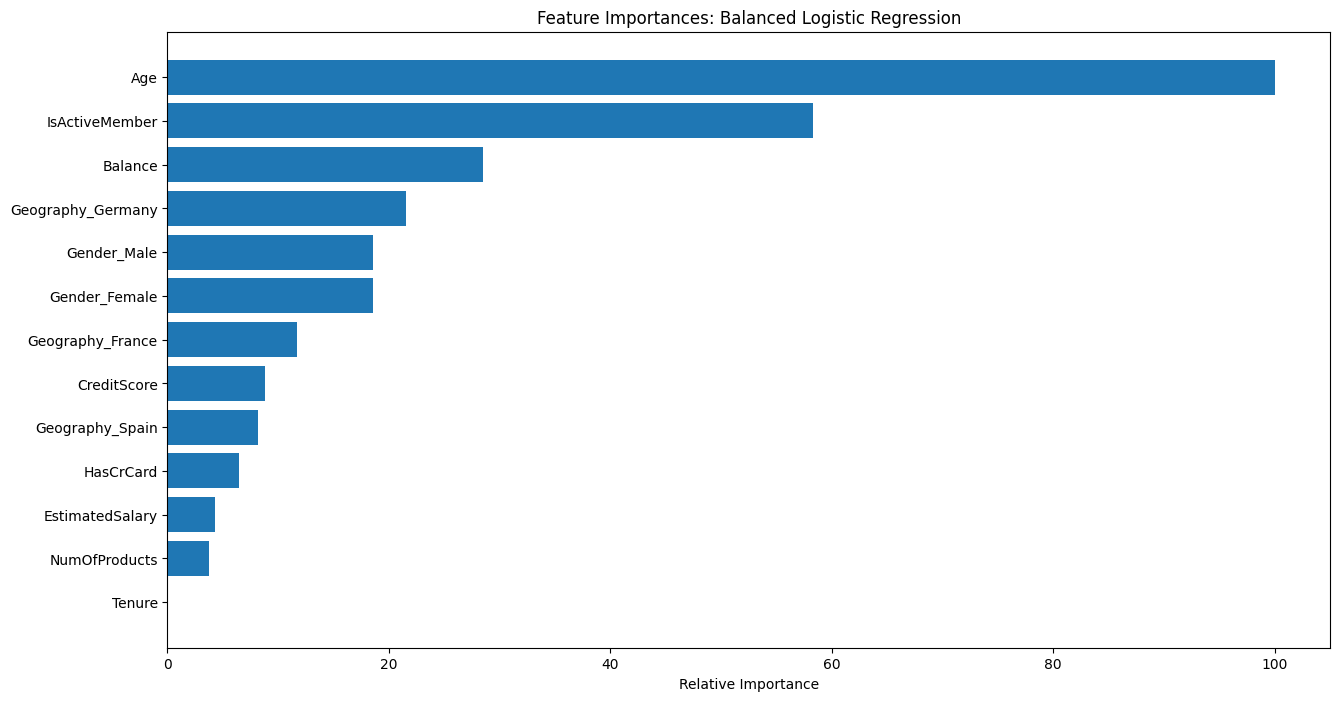

In [ ]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(trainB[features], trainB[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

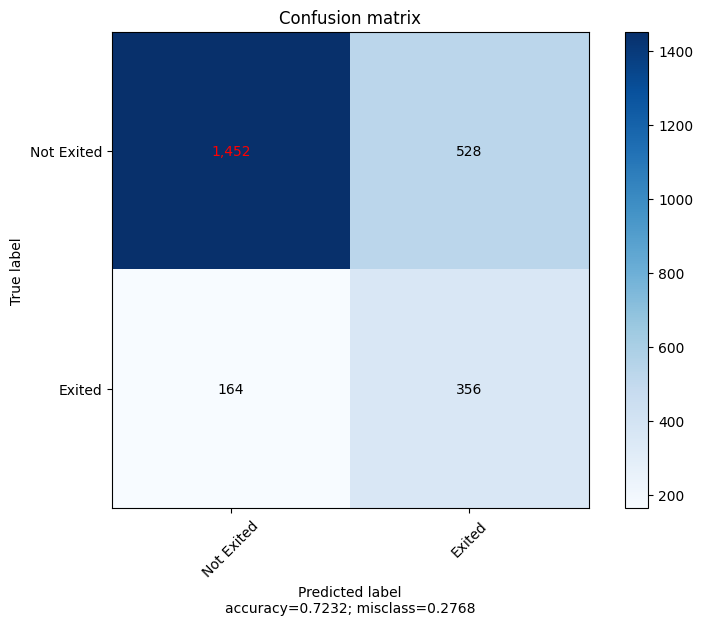

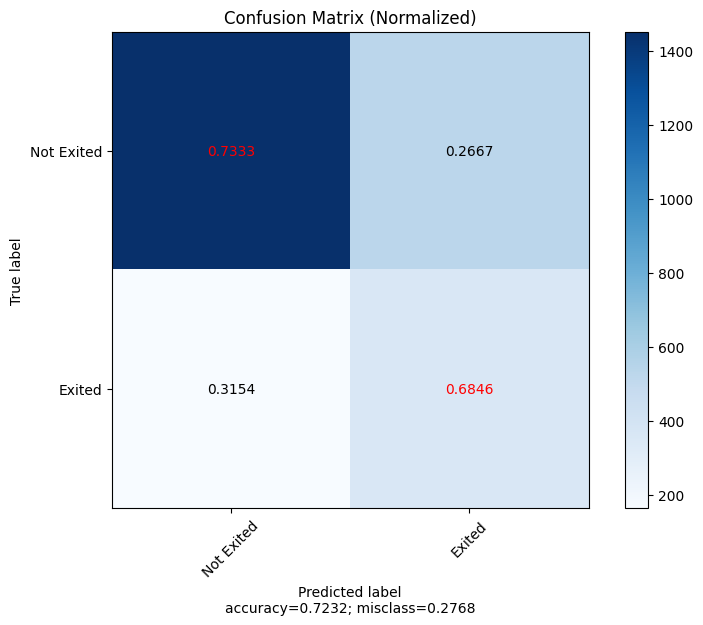

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,yes,0.7232,0.708974,0.77744,0.898515,0.733333,0.807564,0.402715,0.684615,0.507123


In [ ]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression', balanced = 'yes')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

<ipython-input-93-c1cad58f660f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Multi-Layer Perceptron (MLP),yes,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Gradient Boosting (Sklearn),no,0.8660,0.722552,0.875206,0.875742,0.968182,0.919645,0.797428,0.476923,0.596871
0,Gradient Boosting (XGBoost),no,0.8620,0.719318,0.869404,0.874828,0.963636,0.917087,0.774295,0.475000,0.588796
0,Gradient Boosting (LightGBM),no,0.8672,0.733945,0.874539,0.881129,0.962121,0.919845,0.778107,0.505769,0.613054
0,Logistic Regression,yes,0.7232,0.708974,0.777440,0.898515,0.733333,0.807564,0.402715,0.684615,0.507123


#### 2.5.2 MLP: Multi Layers Perceptron

In [ ]:
s = len(features)
parameters = {'hidden_layer_sizes': [(s,),
                                     (s,)*2,
                                     (s,)*4,
                                     (s,)*6],
              'solver': ['lbfgs', 'adam'],
              'alpha': [0, 0.01, 0.1, 1, 10]}
MLP = MLPClassifier()
model_MLP = GridSearchCV(MLP, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_MLP.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:  1.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.971005,0.040249,0.002593,0.000488,0,"(13,)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13,), 'sol...",0.775385,0.758462,...,0.765105,0.008247,16,0.814958,0.812259,0.808552,0.808166,0.819723,0.812731,0.004298
1,3.530164,0.532055,0.007779,0.008680,0,"(13,)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13,), 'sol...",0.764615,0.772308,...,0.769420,0.004349,8,0.786430,0.782961,0.786595,0.780046,0.782357,0.783678,0.002511
2,1.295337,0.224860,0.003989,0.001262,0,"(13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13), '...",0.758462,0.733846,...,0.754007,0.012649,21,0.841172,0.839630,0.834361,0.834746,0.827427,0.835467,0.004822
3,5.174967,1.054086,0.003192,0.000747,0,"(13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13), '...",0.770769,0.766154,...,0.766954,0.007814,15,0.804934,0.808404,0.800077,0.806626,0.803544,0.804717,0.002835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,2.436695,0.287705,0.004588,0.002722,10,"(13, 13, 13, 13)",lbfgs,"{'alpha': 10, 'hidden_layer_sizes': (13, 13, 1...",0.750769,0.780000,...,0.773120,0.011921,5,0.814187,0.813801,0.811633,0.812404,0.820493,0.814504,0.003134
37,6.320260,1.559395,0.003590,0.001197,10,"(13, 13, 13, 13)",adam,"{'alpha': 10, 'hidden_layer_sizes': (13, 13, 1...",0.758462,0.733846,...,0.694513,0.097738,39,0.760601,0.737857,0.500000,0.757704,0.738829,0.698998,0.099938
38,3.384064,1.423817,0.003989,0.000631,10,"(13, 13, 13, 13, 13, 13)",lbfgs,"{'alpha': 10, 'hidden_layer_sizes': (13, 13, 1...",0.778462,0.783077,...,0.720407,0.110250,38,0.798381,0.807247,0.826656,0.500000,0.809322,0.748321,0.124498
39,5.085484,0.475452,0.007180,0.006922,10,"(13, 13, 13, 13, 13, 13)",adam,"{'alpha': 10, 'hidden_layer_sizes': (13, 13, 1...",0.500000,0.500000,...,0.500000,0.000000,40,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [ ]:
print(model_MLP.best_params_)

{'alpha': 1, 'hidden_layer_sizes': (13, 13), 'solver': 'adam'}


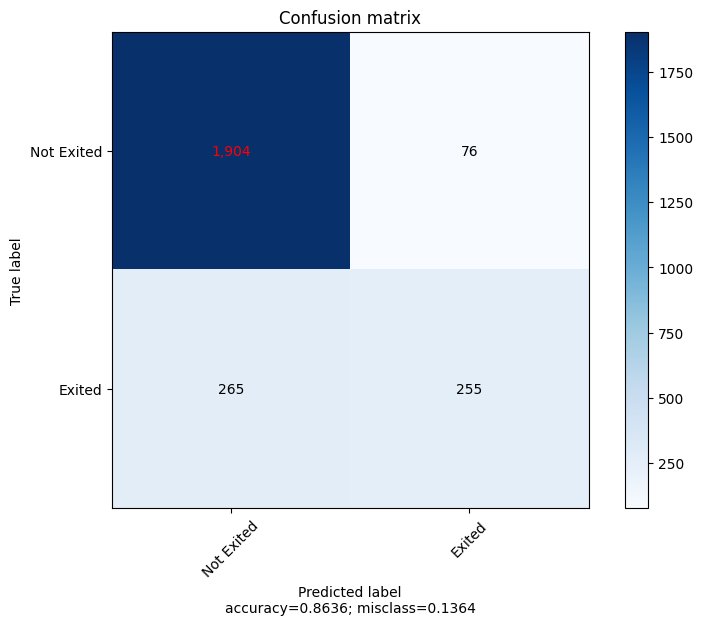

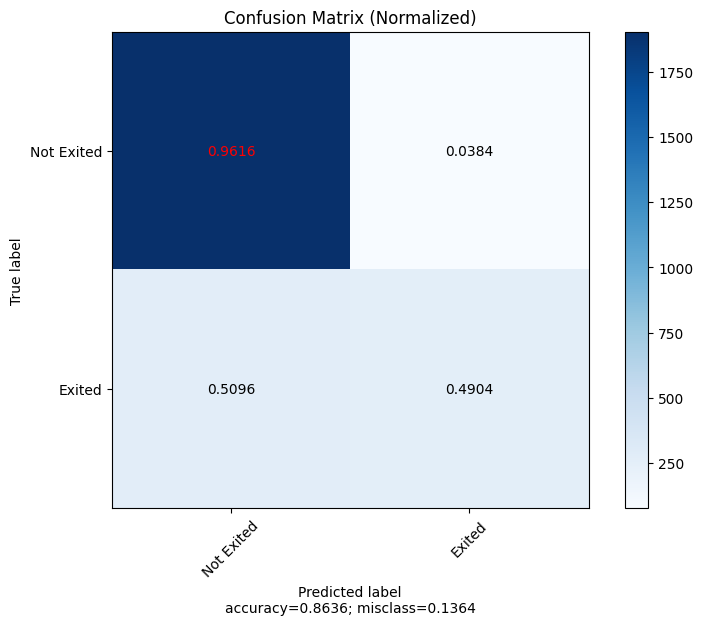

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Multi-Layer Perceptron (MLP),yes,0.8636,0.726,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295


In [ ]:
pred = model_MLP.predict(test[features])
predp = model_MLP.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Multi-Layer Perceptron (MLP)', balanced = 'yes')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

<ipython-input-62-c1cad58f660f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_of_models = table_of_models.append(temp)


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8116,0.581857,0.774679,0.820654,0.975253,0.891299,0.666667,0.188462,0.293853
0,Multi-Layer Perceptron (MLP),no,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295
0,Multi-Layer Perceptron (MLP),yes,0.8636,0.726000,0.870726,0.877824,0.961616,0.917812,0.770393,0.490385,0.599295


#### 2.5.3 Gradient Boosting Classifier (Sklearn)

In [ ]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed:  1.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.261102,0.076714,0.002992,0.000631,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.766154,0.772308,0.779321,...,0.778360,0.008271,6,0.790671,0.787201,0.783513,0.790062,0.787365,0.787762,0.002541
1,0.549332,0.097615,0.004188,0.000399,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.758462,0.783077,0.782407,...,0.780826,0.011714,3,0.803392,0.794140,0.797381,0.801233,0.796225,0.798474,0.003372
2,1.681704,0.305911,0.008577,0.002721,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.749231,0.783077,0.777778,...,0.777127,0.015098,7,0.832305,0.827294,0.830508,0.835901,0.830123,0.831226,0.002836
3,2.862948,0.291889,0.015757,0.006350,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.760000,0.778462,0.770062,...,0.771270,0.007111,10,0.856207,0.853123,0.855547,0.859014,0.849384,0.854655,0.003235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,5.828220,0.426890,0.012168,0.006892,15,50,"{'max_depth': 15, 'n_estimators': 50}",0.701538,0.718462,0.723765,...,0.709309,0.011657,23,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
21,8.936313,0.405102,0.018351,0.008191,15,100,"{'max_depth': 15, 'n_estimators': 100}",0.710769,0.713846,0.733025,...,0.715166,0.011667,21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
22,10.787963,0.578032,0.013962,0.000631,15,300,"{'max_depth': 15, 'n_estimators': 300}",0.706154,0.713846,0.723765,...,0.709309,0.010085,23,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
23,8.083791,0.328812,0.011370,0.001739,15,500,"{'max_depth': 15, 'n_estimators': 500}",0.706154,0.713846,0.739198,...,0.715166,0.012312,21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [ ]:
print(model_GB.best_params_)

{'max_depth': 3, 'n_estimators': 100}


In [ ]:
model = GBSklearn(**model_GB.best_params_)
model.fit(trainB[features], trainB[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: ignored

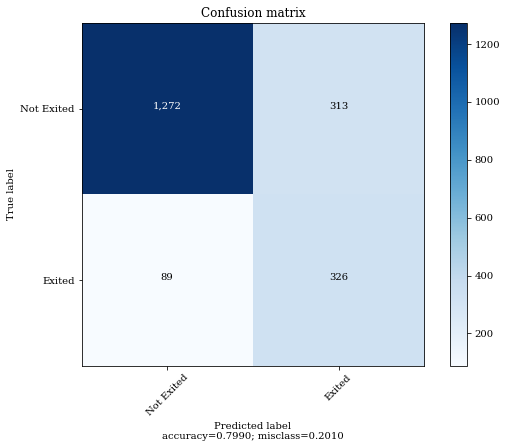

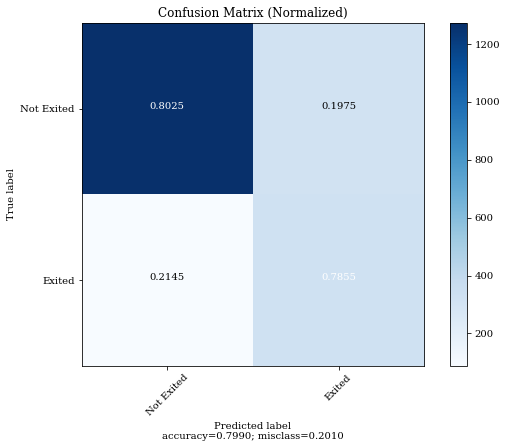

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),yes,0.799,0.794033,0.877831,0.934607,0.802524,0.863544,0.510172,0.785542,0.618596


In [ ]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)', balanced = 'yes')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8115,0.592030,0.777608,0.825081,0.967192,0.890502,0.633803,0.216867,0.323160
0,Multi-Layer Perceptron (MLP),no,0.8640,0.725651,0.871359,0.877950,0.962145,0.918122,0.771863,0.489157,0.598820
0,Gradient Boosting (Sklearn),no,0.8600,0.715123,0.878344,0.873497,0.962776,0.915966,0.766798,0.467470,0.580838
0,Gradient Boosting (XGBoost),no,0.8635,0.722667,0.875068,0.876579,0.963407,0.917944,0.775194,0.481928,0.594354
0,Gradient Boosting (LightGBM),no,0.8690,0.737699,0.881359,0.883034,0.962145,0.920894,0.780220,0.513253,0.619186
0,Logistic Regression,yes,0.7160,0.707871,0.779976,0.900079,0.721767,0.801120,0.395062,0.693976,0.503497
0,Multi-Layer Perceptron (MLP),yes,0.7850,0.772749,0.870068,0.924320,0.793691,0.854039,0.488263,0.751807,0.592030
0,Gradient Boosting (Sklearn),yes,0.7990,0.794033,0.877831,0.934607,0.802524,0.863544,0.510172,0.785542,0.618596


#### 2.5.4 Extreme Gradient Boosting (XGBoost)

In [ ]:
model_XGB = XGB(max_depth = 6,
            learning_rate = .1,
            n_estimators = 100,
            reg_lambda = 0.5,
            reg_alpha = 0,
            verbosity = 1,
            n_jobs = -1,
            tree_method = 'gpu_exact').fit(trainB[features], trainB[target])

pred = model_XGB.predict(test[features])
predp = model_XGB.predict_proba(test[features])[:,1]

importances = model_XGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

TypeError: ignored

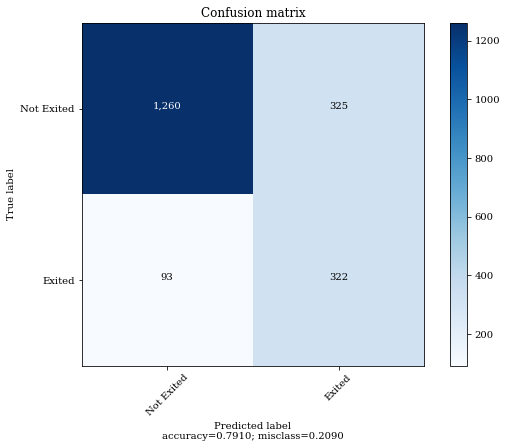

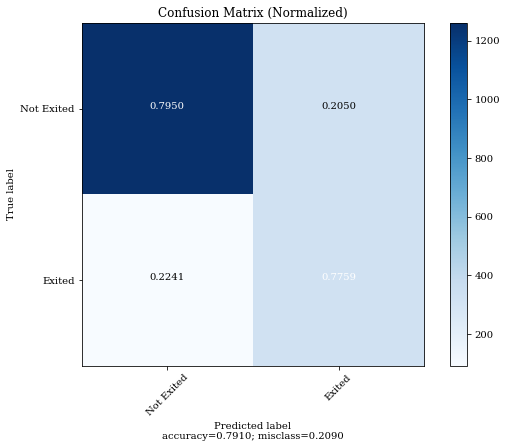

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (XGBoost),yes,0.791,0.785428,0.869156,0.931264,0.794953,0.857726,0.497682,0.775904,0.606403


In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (XGBoost)', balanced = 'yes')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8115,0.592030,0.777608,0.825081,0.967192,0.890502,0.633803,0.216867,0.323160
0,Multi-Layer Perceptron (MLP),no,0.8640,0.725651,0.871359,0.877950,0.962145,0.918122,0.771863,0.489157,0.598820
0,Gradient Boosting (Sklearn),no,0.8600,0.715123,0.878344,0.873497,0.962776,0.915966,0.766798,0.467470,0.580838
0,Gradient Boosting (XGBoost),no,0.8635,0.722667,0.875068,0.876579,0.963407,0.917944,0.775194,0.481928,0.594354
...,...,...,...,...,...,...,...,...,...,...,...
0,Logistic Regression,yes,0.7160,0.707871,0.779976,0.900079,0.721767,0.801120,0.395062,0.693976,0.503497
0,Multi-Layer Perceptron (MLP),yes,0.7850,0.772749,0.870068,0.924320,0.793691,0.854039,0.488263,0.751807,0.592030
0,Gradient Boosting (Sklearn),yes,0.7990,0.794033,0.877831,0.934607,0.802524,0.863544,0.510172,0.785542,0.618596
0,Gradient Boosting (XGBoost),yes,0.7910,0.785428,0.869156,0.931264,0.794953,0.857726,0.497682,0.775904,0.606403


#### 2.5.5 Light Gradient Boosting Machine (LightGBM)

In [ ]:
train_data = lgb.Dataset(trainB[features],
                         label = trainB[target],
                         feature_name = features)
test_data = lgb.Dataset(test[features + [target]],
                              reference = train_data)

In [ ]:
param = {'num_leaves': 21,
         'num_trees': 100,
         # 'max_depth': 20,
         'objective': 'binary',
         # 'boosting': 'dart',
         'lambda_l1': 1,
         'lambda_l2': 1,
         'learning_rate': 0.1,
         'metric': ['binary_logloss', 'binary_error'],
         'seed': 1}

num_round = 10
model_LGB = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's binary_logloss: 0.674855	valid_0's binary_error: 0.3585
[2]	valid_0's binary_logloss: 0.661192	valid_0's binary_error: 0.371
[3]	valid_0's binary_logloss: 0.651515	valid_0's binary_error: 0.343
[4]	valid_0's binary_logloss: 0.643541	valid_0's binary_error: 0.34
[5]	valid_0's binary_logloss: 0.638305	valid_0's binary_error: 0.343
[6]	valid_0's binary_logloss: 0.634442	valid_0's binary_error: 0.3455
[7]	valid_0's binary_logloss: 0.63218	valid_0's binary_error: 0.346
[8]	valid_0's binary_logloss: 0.632156	valid_0's binary_error: 0.3475
[9]	valid_0's binary_logloss: 0.63273	valid_0's binary_error: 0.333
[10]	valid_0's binary_logloss: 0.633086	valid_0's binary_error: 0.3385
[11]	valid_0's binary_logloss: 0.633887	valid_0's binary_error: 0.3385
[12]	valid_0's binary_logloss: 0.634107	valid_0's binary_error: 0.3325
[13]	valid_0's binary_logloss: 0.635837	valid_0's binary_error: 0.332
[14]	valid_0's binary_logloss: 0.636673	valid_0's binary_error: 0.328
[15]	valid_0's binary_logl

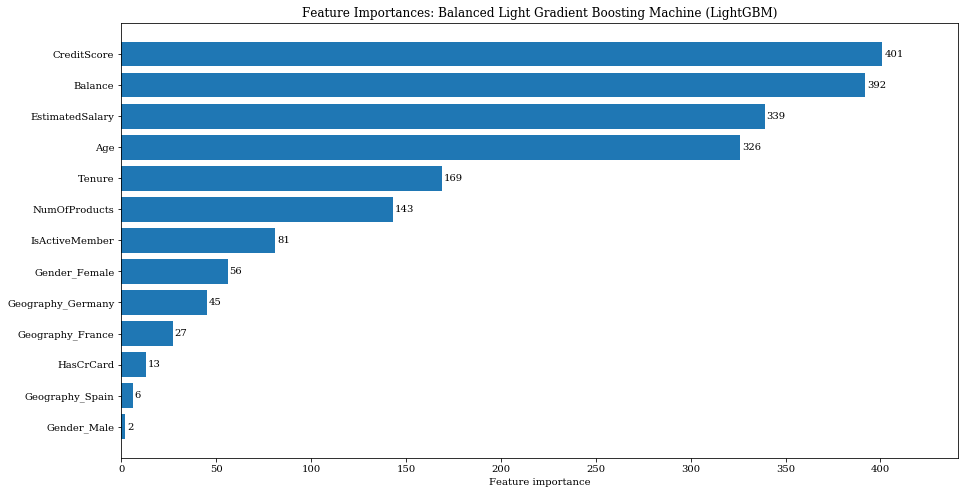

In [ ]:
predp = model_LGB.predict(test[features])
pred = predp > 0.5

lgb.plot_importance(model_LGB,
                    figsize = (15,8),
                    height = 0.8,
                    title = 'Feature Importances: Balanced Light Gradient Boosting Machine (LightGBM)',
                    ylabel = None,
                    grid = False)

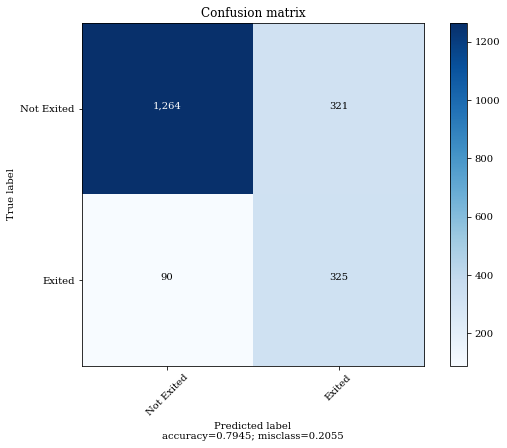

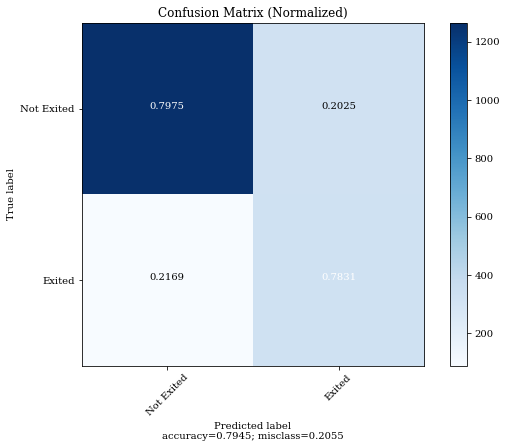

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (LightGBM),yes,0.7945,0.790304,0.871768,0.93353,0.797476,0.860157,0.503096,0.783133,0.61263


In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (LightGBM)', balanced = 'yes')
temp

In [ ]:
table_of_models = table_of_models.append(temp)
table_of_models

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8115,0.592030,0.777608,0.825081,0.967192,0.890502,0.633803,0.216867,0.323160
0,Multi-Layer Perceptron (MLP),no,0.8640,0.725651,0.871359,0.877950,0.962145,0.918122,0.771863,0.489157,0.598820
0,Gradient Boosting (Sklearn),no,0.8600,0.715123,0.878344,0.873497,0.962776,0.915966,0.766798,0.467470,0.580838
0,Gradient Boosting (XGBoost),no,0.8635,0.722667,0.875068,0.876579,0.963407,0.917944,0.775194,0.481928,0.594354
...,...,...,...,...,...,...,...,...,...,...,...
0,Multi-Layer Perceptron (MLP),yes,0.7850,0.772749,0.870068,0.924320,0.793691,0.854039,0.488263,0.751807,0.592030
0,Gradient Boosting (Sklearn),yes,0.7990,0.794033,0.877831,0.934607,0.802524,0.863544,0.510172,0.785542,0.618596
0,Gradient Boosting (XGBoost),yes,0.7910,0.785428,0.869156,0.931264,0.794953,0.857726,0.497682,0.775904,0.606403
0,Gradient Boosting (LightGBM),yes,0.7945,0.790304,0.871768,0.933530,0.797476,0.860157,0.503096,0.783133,0.612630


# 2.5.6  ADA Boost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

In [ ]:
clf = GridSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=-1).fit(trainB[features], trainB[target])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
clf.best_parameters_

In [ ]:
pred = clf.predict(test[features])
predp = clf.predict_proba(test[features])[:,1]

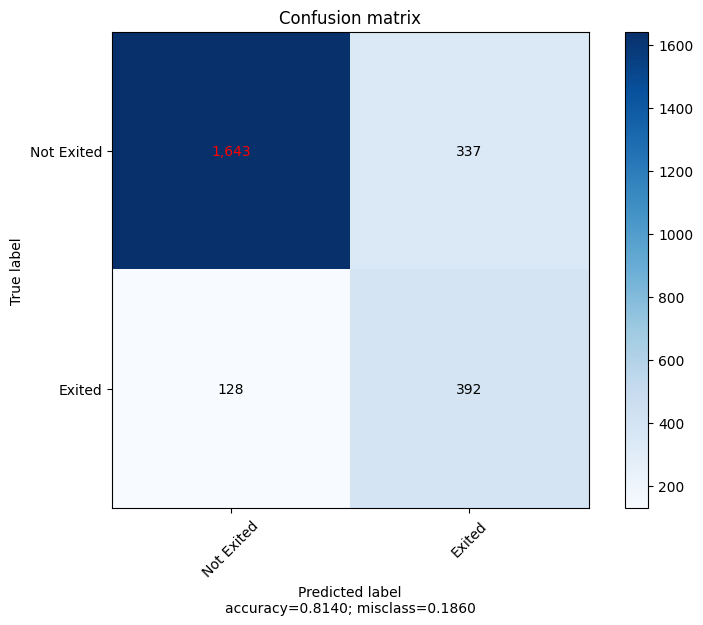

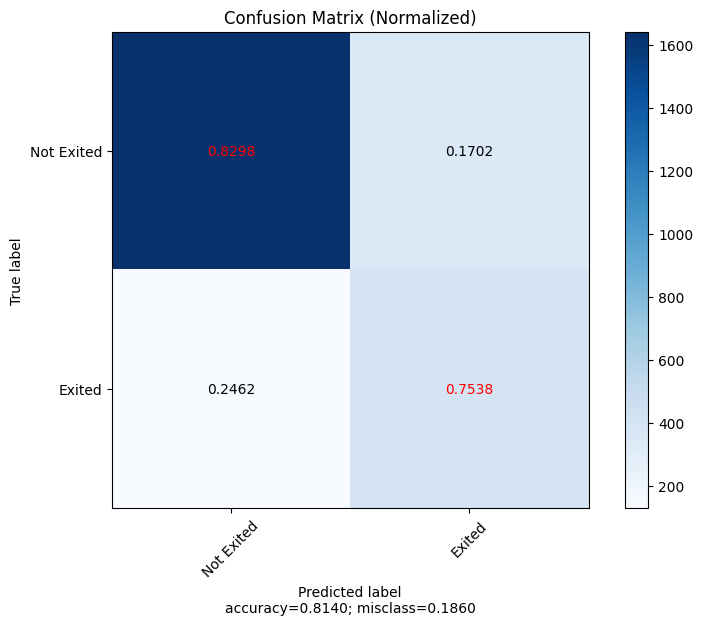

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Ada Boosting,yes,0.814,0.791822,0.875454,0.927724,0.829798,0.876033,0.537723,0.753846,0.627702


In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Ada Boosting', balanced = 'yes')
temp

# 2.5.7 Kernel SVM

In [ ]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
KSVM = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
KSVM.fit(trainB[features], trainB[target])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  13.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  11.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   8.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  15.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  15.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.4s
[CV] END .....................C=0.1, gamma=1, k

In [ ]:
pred = KSVM.predict(test[features])
predp = KSVM.predict_proba(test[features])[:,1]

In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'KSVM Boosting', balanced = 'yes')
temp

# CAT Boost

In [ ]:
from catboost import CatBoostClassifier
CB = CatBoostClassifier()


In [ ]:
parameters = { 'depth' : [4,5,6,7,8,9, 10],
               'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
             }

In [ ]:
Grid_CBC = GridSearchCV(estimator=CB, param_grid = parameters, cv = 2, n_jobs=-1).fit(trainB[features], trainB[target])
pred = Grid_CBC.predict(test[features])
predp = Grid_CBC.predict_proba(test[features])[:,1]

'''importances = Grid_CBC.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()'''


0:	learn: 0.6816790	total: 3.35ms	remaining: 332ms
1:	learn: 0.6715293	total: 6.55ms	remaining: 321ms
2:	learn: 0.6619940	total: 9.04ms	remaining: 292ms
3:	learn: 0.6523829	total: 10.3ms	remaining: 247ms
4:	learn: 0.6438264	total: 11.6ms	remaining: 221ms
5:	learn: 0.6348975	total: 14ms	remaining: 220ms
6:	learn: 0.6270104	total: 16.5ms	remaining: 219ms
7:	learn: 0.6199432	total: 19ms	remaining: 219ms
8:	learn: 0.6118911	total: 21.5ms	remaining: 217ms
9:	learn: 0.6048965	total: 23.9ms	remaining: 215ms
10:	learn: 0.5989412	total: 26.4ms	remaining: 214ms
11:	learn: 0.5924440	total: 28.9ms	remaining: 212ms
12:	learn: 0.5870486	total: 31.5ms	remaining: 211ms
13:	learn: 0.5813170	total: 33.9ms	remaining: 208ms
14:	learn: 0.5766451	total: 36.3ms	remaining: 206ms
15:	learn: 0.5718897	total: 38.7ms	remaining: 203ms
16:	learn: 0.5669583	total: 41.3ms	remaining: 202ms
17:	learn: 0.5624992	total: 43.5ms	remaining: 198ms
18:	learn: 0.5582307	total: 45.3ms	remaining: 193ms
19:	learn: 0.5541099	total

AttributeError: ignored

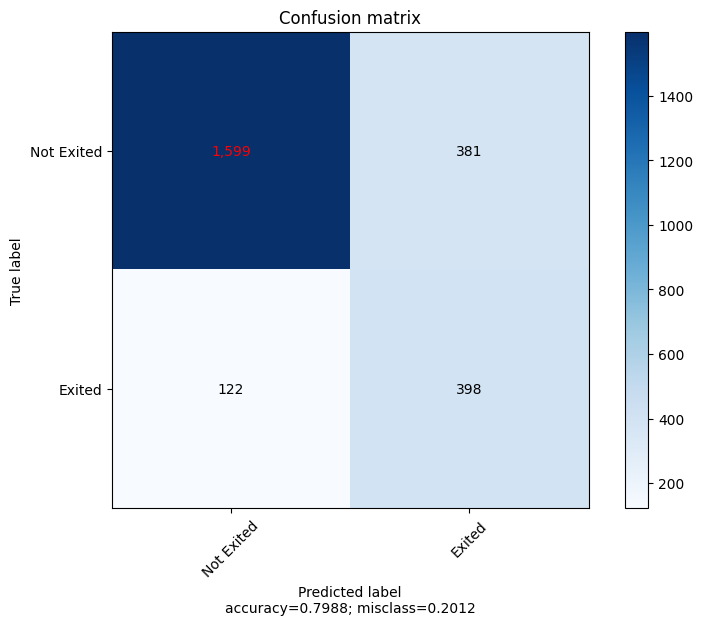

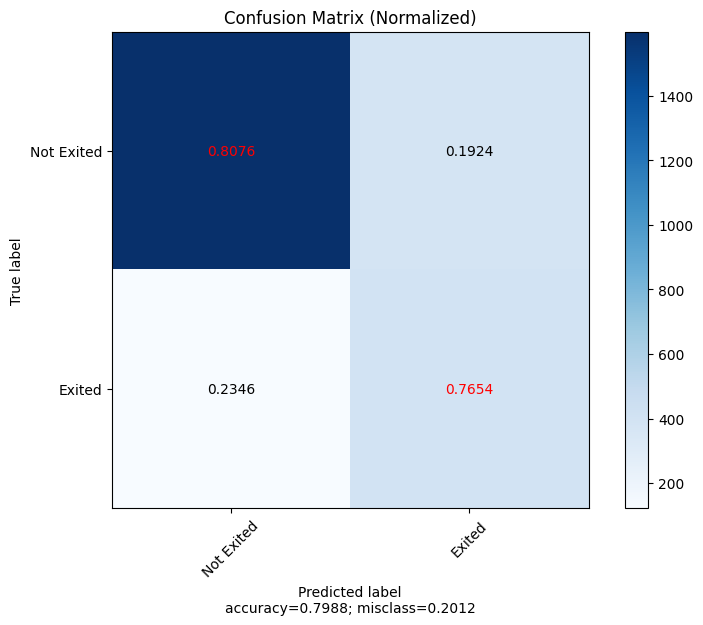

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Cat Boosting,yes,0.7988,0.78648,0.87302,0.929111,0.807576,0.864091,0.510911,0.765385,0.612779


In [ ]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Cat Boosting', balanced = 'yes')
temp

In [ ]:
table_of_models.to_excel('table_of_models.xlsx', index = False)

# Conclusions

In this notebook, the focus is to try different algorithms to evaluate their performance on `bank customer churn` data. Also the imbalance in data is addressed.

Financial organizations are having difficulty retaining consumers. It has become necessary to monitor customer account health in order to take preventative measures for retention. Machine learning algorithms can undoubtedly assist them in analyzing consumer status and lowering churn rates. This research performed an extensive exploratory analysis of churn data in order to visualize the relationships between the qualities in several dimensions. The effectiveness of linear, non-linear, and boosting classifiers is investigated. The dataset used in the study contains an imbalance in the churn/no churn category. As a result, random sampling is used to balance the dataset. The various classifiers are then applied to the balanced dataset in order to investigate the influence of the imbalanced dataset on the target value. It has been discovered that an imbalanced dataset has a bias in the performance measures. The results show that the Ada boosting classifier performs effectively on the balanced churn data used in the study.